# Notebook for analysing all VR trials of one experimental group from REINFORCEMENT TEST trials

## Assumes use of FlyOver version 9.4 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRoptogenetics/')
from flyVRoptogenetics_oneTrialBasicAnalysis import singleVROptogenTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, residencyWithHistograms,\
        oneDimResidencyWithVar_df, radDistAngleCombiPlot, make4ValuePolCoordPlot

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import cartesian2polar, polarCurvature, countVisits, countVisits_df, visitTime_df
from plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, plotVeloHeadingDistribution2_flyVR_df,\
                               oneDimResidency_df, oneDimResidencyWithVar_df, turnRatePerDistance
from circularStatsOnTrajectories import circmeanvec, RayleighTest, fractional_polar_axes

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import rZoneParamsFromLogFile

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep


try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')

/Users/hannah/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [2]:
#my_indices = [2,3,4,7,8,9,10,12,13,14,15,16,19,20]
#expDirs = [expDirs[i] for i in my_indices]
expDirs = expDirs[:25]

expDirs

['m01',
 'm02',
 'm03',
 'm04',
 'm05',
 'm06',
 'm07',
 'm08',
 'm09',
 'm10',
 'm11',
 'm12',
 'm13',
 'm14',
 'm15',
 'm16',
 'm17',
 'm18',
 'm19',
 'm20',
 'm21',
 'm22',
 'm23',
 'm24',
 'm25']

### Compose mutli-fly data into dataframe

In [3]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [4]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [5]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsVI = 0
nTrialsIN = 0
nTrialsR = 0
nTrialsNR = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[4]
        genotype = fileToAnalyse.split('_')[3]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        if 'rZones' in fileToAnalyse:
            rZones = 'on'
            nTrialsR += 1
        else:
            rZones = 'off'
            nTrialsNR += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/10BL-30max/males/rawData/m01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHexLED40mm30per10bl_HCx10ChrRWTB_m01_7-9d_none_out_170210132543.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per10bl_HCx10ChrRWTB_m01_7-9d_none_out_170210134932.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per10bl_HCx10ChrRWTB_m01_7-9d_rZones_out_170210133741.txt', 'singleObjectForest_1cm4cmInvisibleCone_12cmHexLED40mm30per10bl_HCx10ChrRWTB_m01_7-9d_rZones_out_170210141012.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/10BL-30max/males/rawData/m02/

 Analysing the following log files:

['si

In [6]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

flyID trial  trialtype reinforcement  moving  curvature     gamma  \
0       m01   1.0    visible           off     1.0        NaN       NaN   
1       m01   1.0    visible           off     1.0        NaN       NaN   
2       m01   1.0    visible           off     1.0        NaN       NaN   
3       m01   1.0    visible           off     1.0        NaN       NaN   
4       m01   1.0    visible           off     1.0        NaN       NaN   
5       m01   1.0    visible           off     1.0        NaN       NaN   
6       m01   1.0    visible           off     1.0        NaN       NaN   
7       m01   1.0    visible           off     1.0        NaN       NaN   
8       m01   1.0    visible           off     1.0        NaN       NaN   
9       m01   1.0    visible           off     1.0        NaN       NaN   
10      m01   1.0    visible           off     1.0        NaN       NaN   
11      m01   1.0    visible           off     1.0        NaN       NaN   
12      m01   1.0    visible           off     1.0        NaN       NaN   
13      m01   1.0    visible           off     1.0        NaN       NaN   
14      m01   1.0    visible           off     1.0        NaN       NaN   
15      m01   1.0    visible           off     1.0        NaN       NaN   
16      m01   1.0    visible           off     1.0        NaN  1.398609   
17      m01   1.0    visible           off     1.0        NaN  1.427483   
18      m01   1.0    visible           off     1.0        NaN  1.449647   
19      m01   1.0    visible           off     1.0        NaN  1.474604   
20      m01   1.0    visible           off     1.0        NaN  1.502644   
21      m01   1.0    visible           off     1.0        NaN  1.530701   
22      m01   1.0    visible           off     1.0        NaN  1.547655   
23      m01   1.0    visible           off     1.0        NaN  1.567001   
24      m01   1.0    visible           off     1.0        NaN  1.581800   
25      m01   1.0    visible           off     1.0        NaN  1.592037   
26      m01   1.0    visible           off     1.0        NaN  1.605535   
27      m01   1.0    visible           off     1.0        NaN  1.618335   
28      m01   1.0    visible           off     1.0        NaN  1.622841   
29      m01   1.0    visible           off     1.0        NaN       NaN   
...     ...   ...        ...           ...     ...        ...       ...   
11970   m25   4.0  invisible            on     1.0        NaN  1.379333   
11971   m25   4.0  invisible            on     1.0        NaN  1.320712   
11972   m25   4.0  invisible            on     1.0        NaN  1.273288   
11973   m25   4.0  invisible            on     1.0        NaN  1.242631   
11974   m25   4.0  invisible            on     1.0        NaN  1.247113   
11975   m25   4.0  invisible            on     1.0        NaN  1.283508   
11976   m25   4.0  invisible            on     0.0        NaN  1.367225   
11977   m25   4.0  invisible            on     0.0        NaN  1.450650   
11978   m25   4.0  invisible            on     0.0        NaN  1.496776   
11979   m25   4.0  invisible            on     1.0        NaN  1.485993   
11980   m25   4.0  invisible            on     1.0        NaN  1.452730   
11981   m25   4.0  invisible            on     1.0        NaN  1.444301   
11982   m25   4.0  invisible            on     1.0        NaN  1.466065   
11983   m25   4.0  invisible            on     0.0        NaN  1.476362   
11984   m25   4.0  invisible            on     0.0        NaN  1.491571   
11985   m25   4.0  invisible            on     0.0        NaN  1.527484   
11986   m25   4.0  invisible            on     0.0        NaN  1.544262   
11987   m25   4.0  invisible            on     0.0        NaN  1.533553   
11988   m25   4.0  invisible            on     1.0        NaN  1.511587   
11989   m25   4.0  invisible            on     0.0        NaN  1.506953   
11990   m25   4.0  invisible            on     0.0        NaN  1.508541   
11991   m25   4.0  invisible   

In [7]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_objD = keylistLong.index('objectDistance')
keyind_event = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [8]:
# Reinforcement test
rZoneState = ['off','off','on','on']
visibilityState = ['visible','visible','visible','invisible']
groundPlane = ['textured']
trialOrder = [0,2,1,3]
trialName = ['obj (1)','obj (3)','obj + opt (2)','opt (4)']
arenaRad = 60

rZone_rInner, rZone_rOuter, rZone_max, rZone_bl, rZone_gExp = rZoneParamsFromLogFile(expDir, fileToAnalyse)

In [9]:
%matplotlib inline 

### Select subset of flies based on walking activity

In [35]:
for fly in range(numFlies):
    querystring = '(flyID == "'+ flyIDs[fly] +  '")'
    perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')

    percentMoving = (100.0*sum(perFlyMoving))/max(1,len(perFlyMoving))

    if percentMoving >= 25.0:
        #print(percentMoving)
        print(flyIDs[fly]) 

m01
m02
m03
m04
m05
m06
m07
m08
m09
m10
m11
m12
m13
m14
m15
m16
m17
m18
m19
m20
m21
m22
m23
m24
m25


In [24]:
trial = 0
for fly in range(numFlies):
            
    querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
    perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')

    percentMoving = (100.0*sum(perFlyMoving))/max(1,len(perFlyMoving))

    if percentMoving >= 25.0:
        print(flyIDs[fly] + ' trial '+ str(trial+1))        

m01 trial 1
m03 trial 1
m04 trial 1
m05 trial 1
m06 trial 1
m07 trial 1
m08 trial 1
m09 trial 1
m10 trial 1


### Trajectory plots of all trials

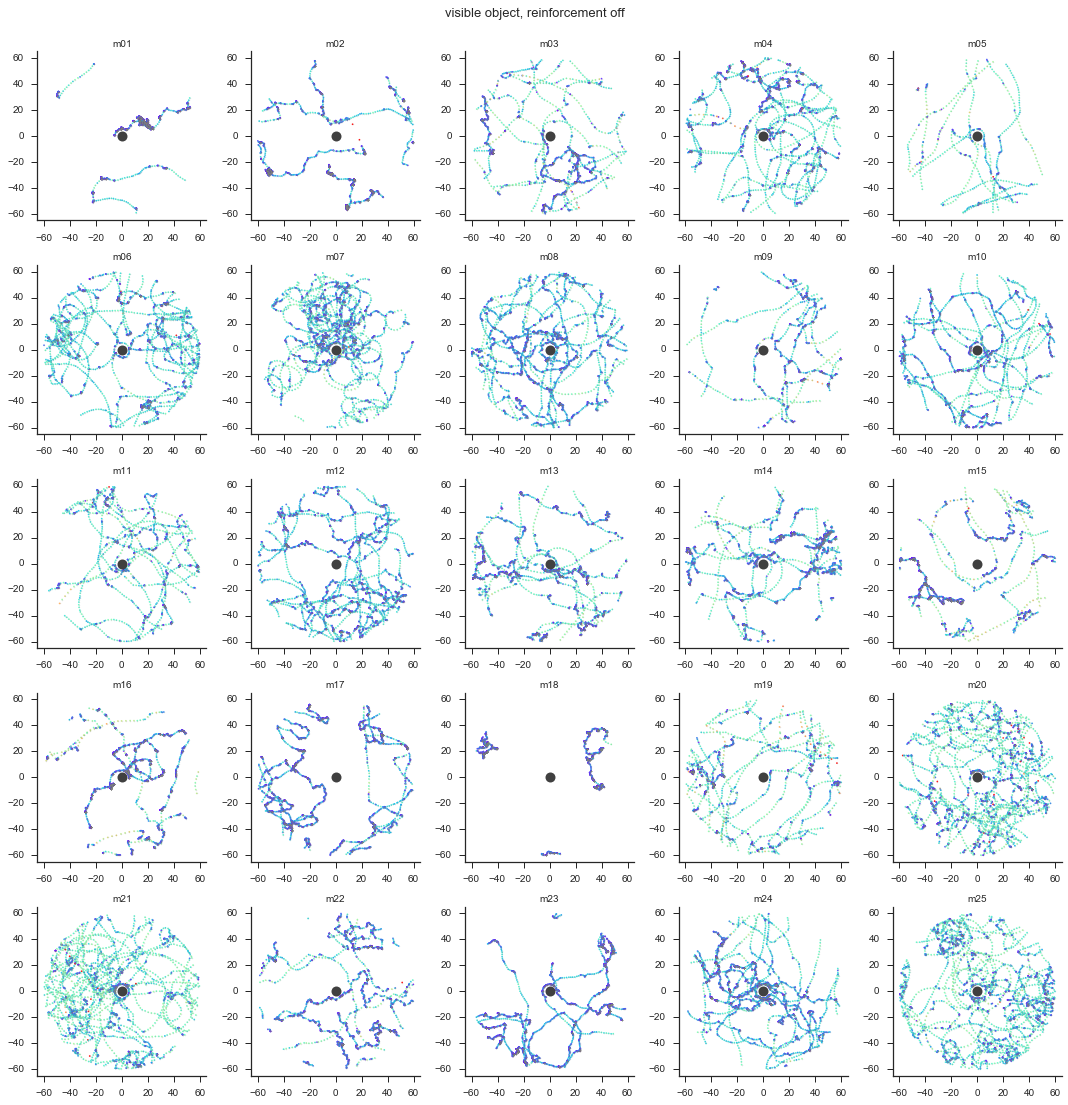

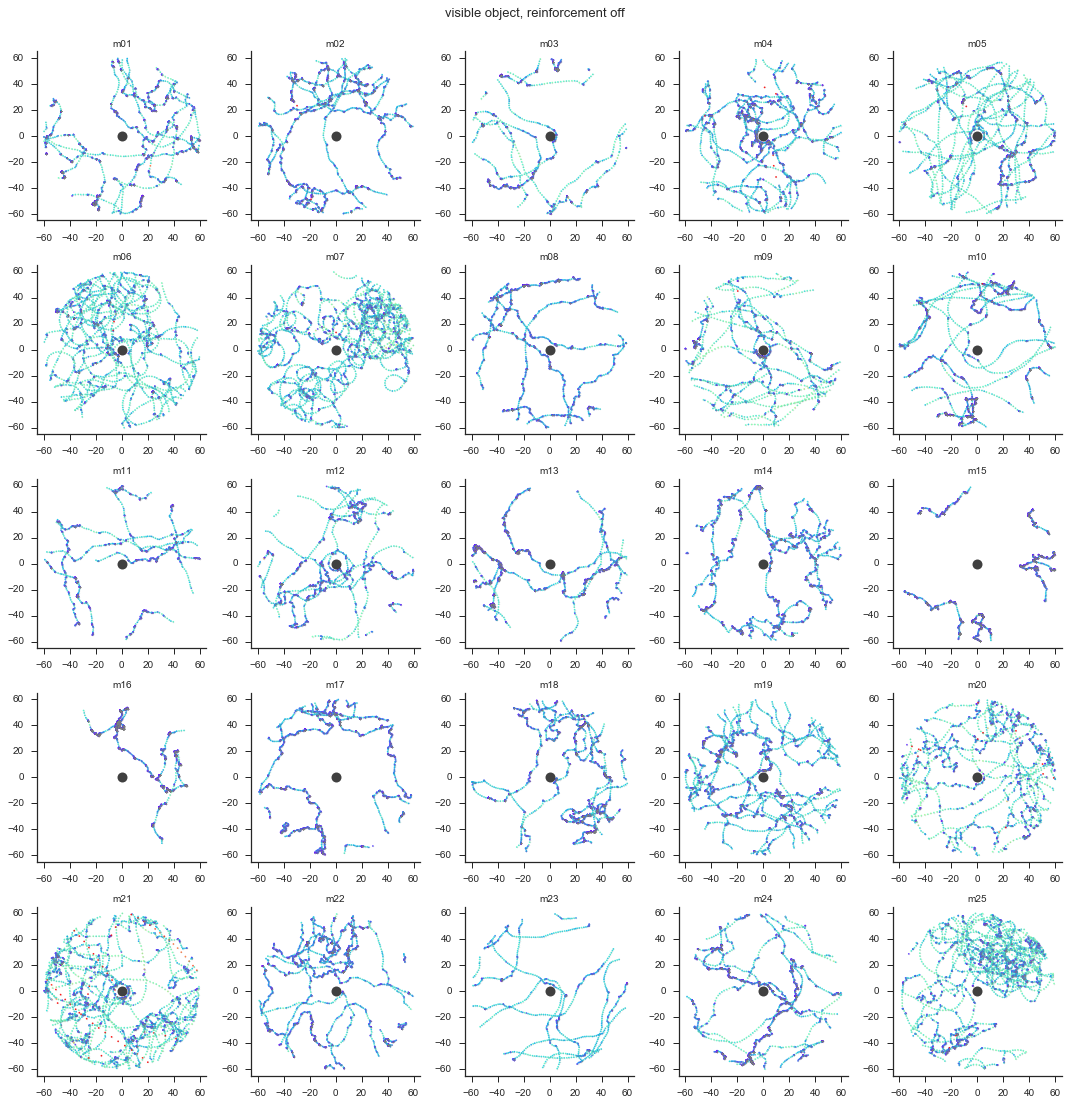

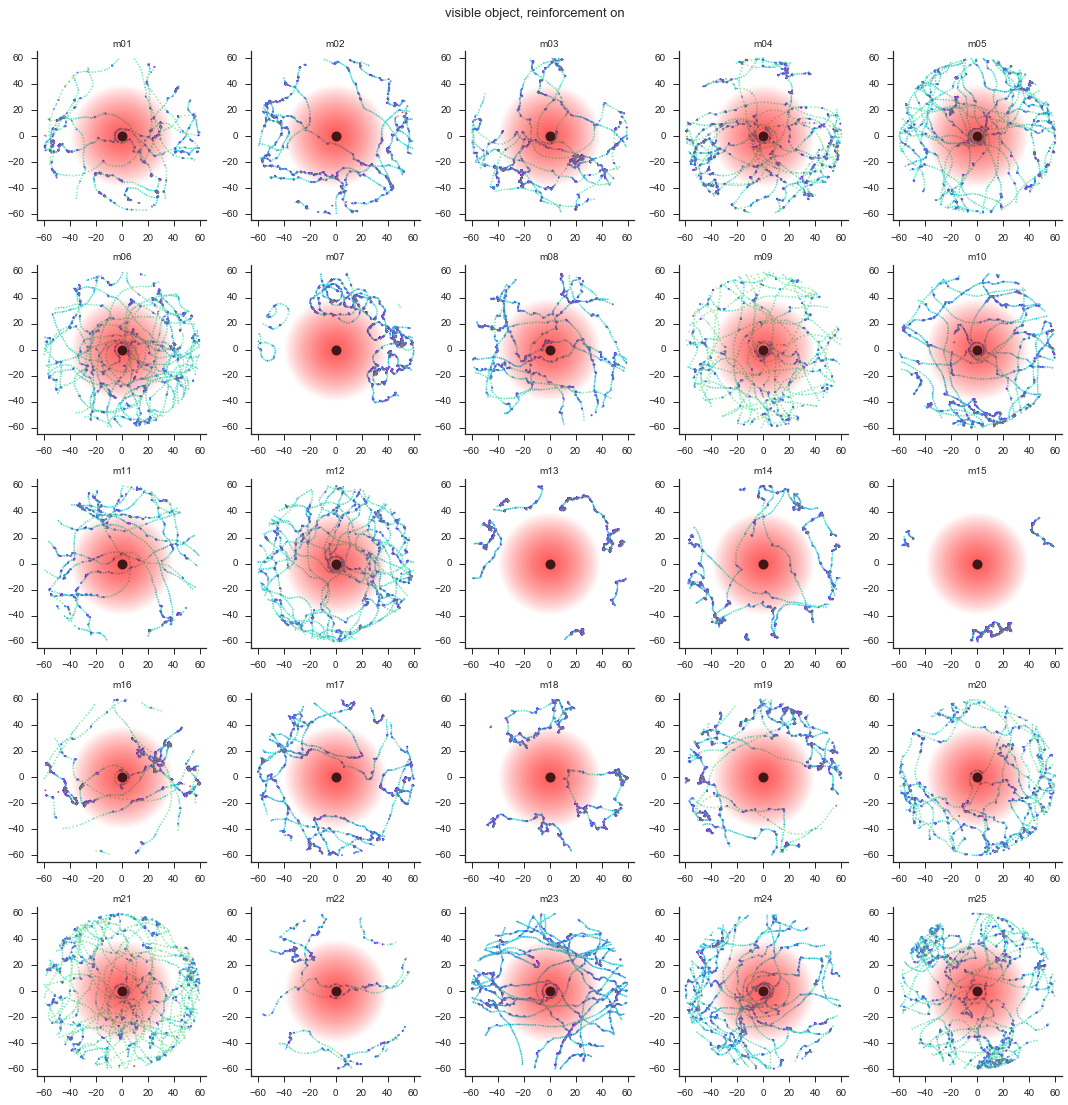

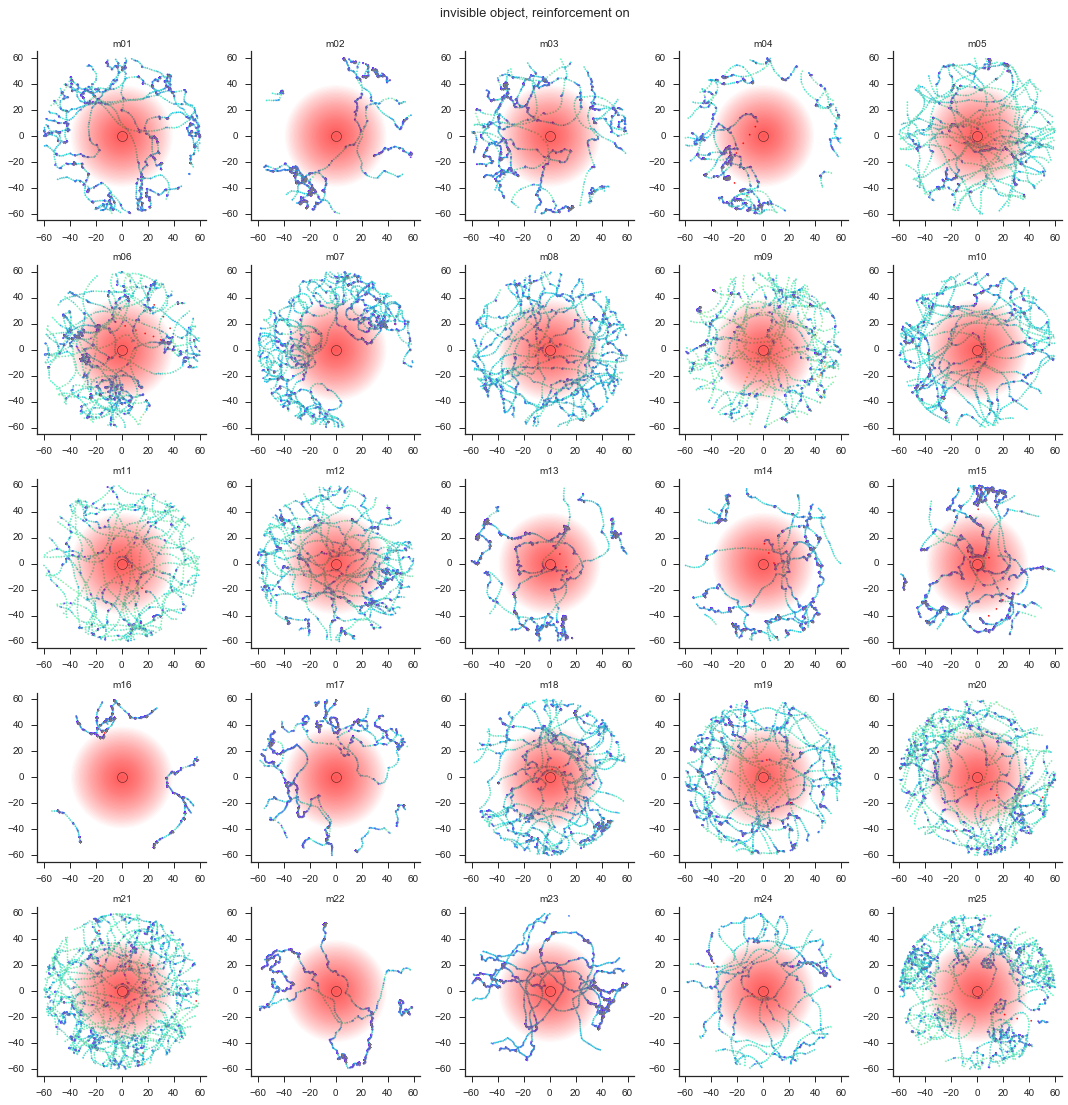

In [27]:
nrows = np.ceil(numFlies/5.0)
for ttind,trialtype in enumerate(visibilityState):
    multiflyTracePlot = plt.figure(figsize=(15,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object, reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,5,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (trial==' + str(ttind+1) + ') & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        
        selectPts = range(0,len(perFlyX),3)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        if (trialtype == 'visible'):
            multiflyTracePlot_sbplt.plot(0, 0, marker='o', markersize=10, linestyle='none', alpha=0.75, color='black')
        else:
            multiflyTracePlot_sbplt.plot(0, 0, marker='o', markersize=10, alpha=0.75, markeredgewidth=0.5,
                                         markerfacecolor='None',markeredgecolor='black')

        if(rZoneState[ttind]=='on'):
            rZoneRange = float(rZone_rOuter - rZone_rInner)
            for zRad in range(rZone_rInner, rZone_rOuter):
                circle1 = plt.Circle((0, 0), zRad, color='r', alpha=1.0/rZoneRange)
                multiflyTracePlot_sbplt.add_artist(circle1)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-arenaRad-5, arenaRad + 5)
        multiflyTracePlot_sbplt.set_ylim(-arenaRad-5, arenaRad + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_rZones'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

### Velocity and relative heading distributions

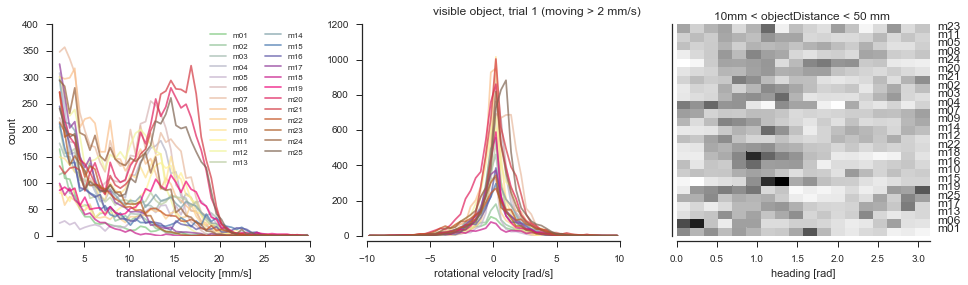

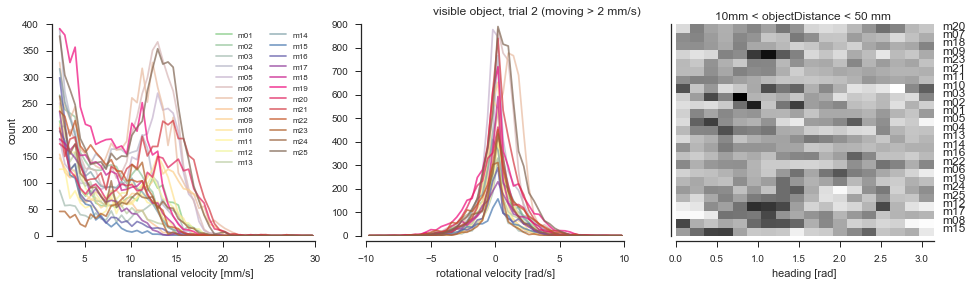

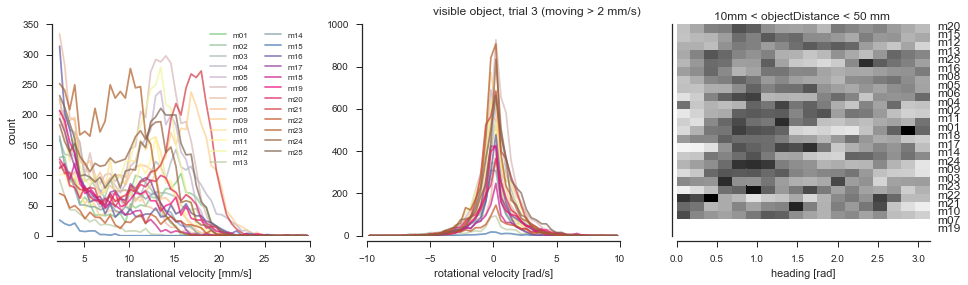

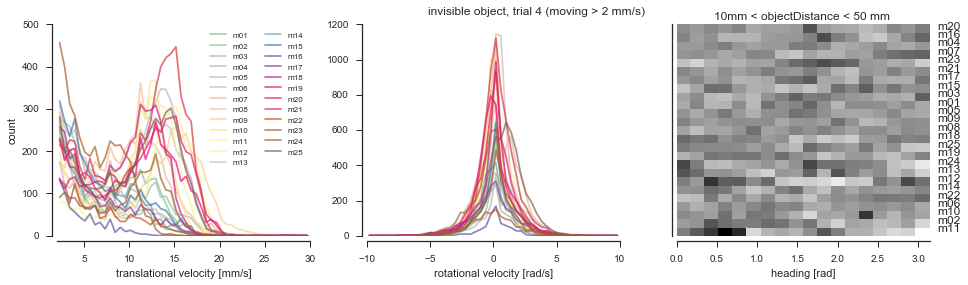

In [28]:
for ttind,trialtype in enumerate(visibilityState):
    
    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong,
                                                       vTransTH, 10, 50)
    veloDistFig.tight_layout()
    
    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
                + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

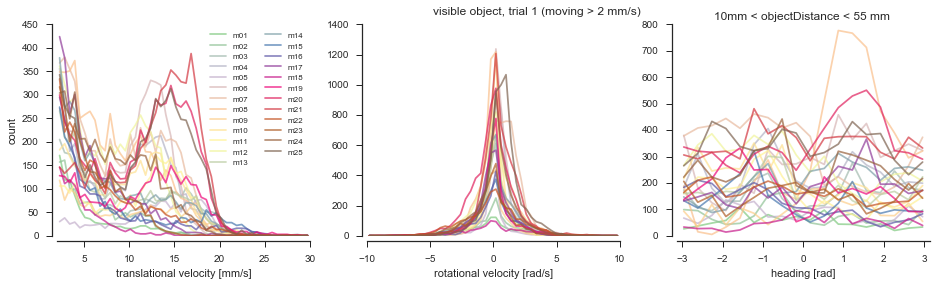

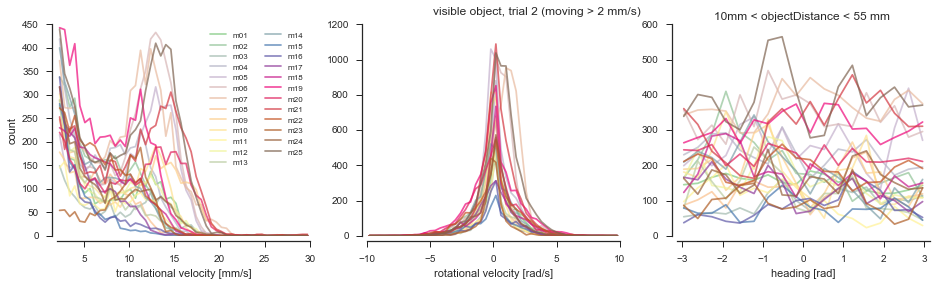

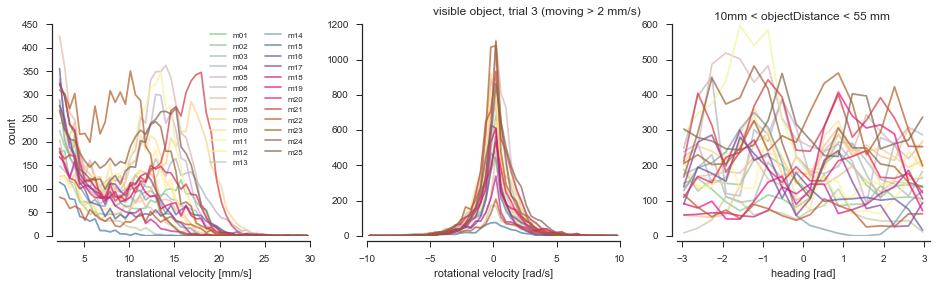

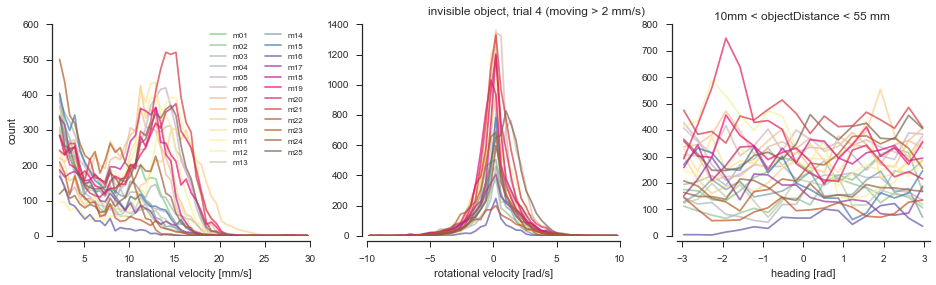

In [29]:
for ttind,trialtype in enumerate(visibilityState):
    veloDistFig = plotVeloHeadingDistribution2_flyVR_df(FOAllFlies_df,'all',trialtype, str(ttind+1), flyIDs, keylistLong,
                                                        vTransTH,10,55)
    veloDistFig.tight_layout()

    veloDistFig.savefig(analysisDir + 'velocityTraces/'+ genotype +'_'+flyIDs[0][0]+ '_' + trialtype + '_rZones' + rZoneState[ttind]
                + '_veloDistributions2_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

## Residency

### 2D (cartesian) residency

Plot directory already exists


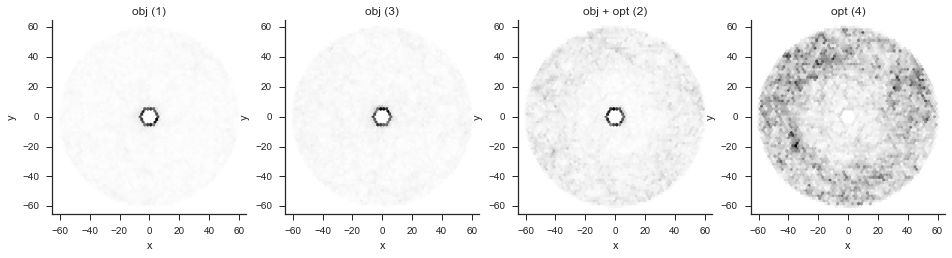

In [10]:
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

hexplotfig = plt.figure(figsize=(16,4))
for trial, condition in enumerate(trialName):
    querystring = '(trial == ' + str(trial+1) + ') & (moving > 0)'
    xPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMA = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    ax = hexplotfig.add_subplot(1,4,trial+1)
    ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys')
    plt.xlabel('x'); plt.ylabel('y')
    ax.set_xlim(-arenaRad-5, arenaRad+5); ax.set_ylim(-arenaRad-5, arenaRad+5)
    ax.set_title(trialName[trial])
    ax.set_aspect('equal')
    myAxisTheme(ax)

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')


Plot directory already exists
Plot directory already exists
Plot directory already exists
Plot directory already exists


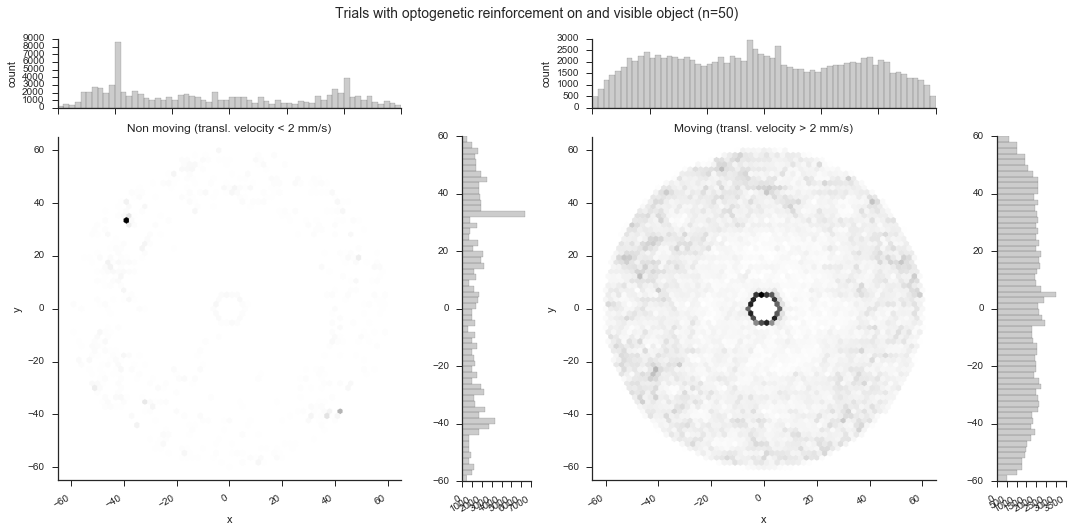

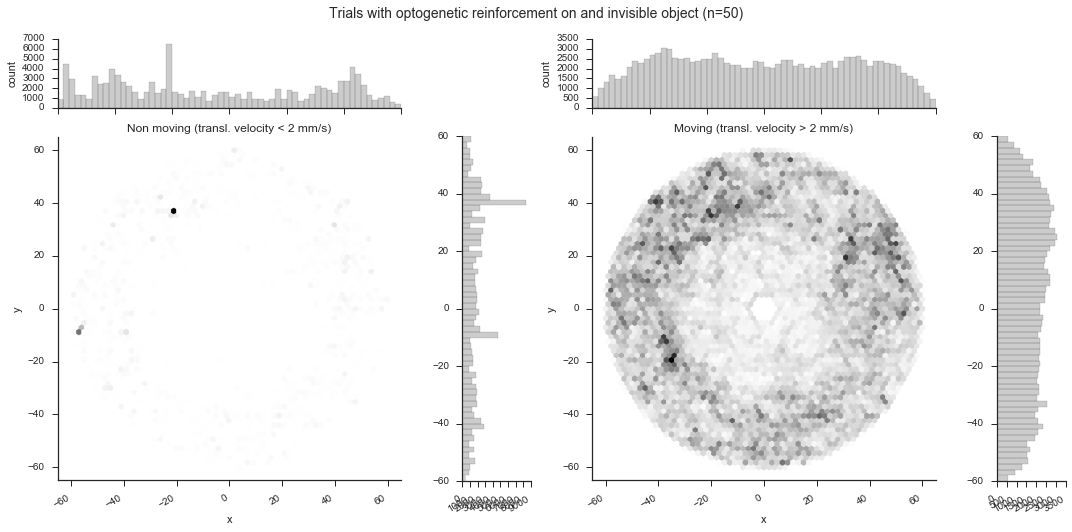

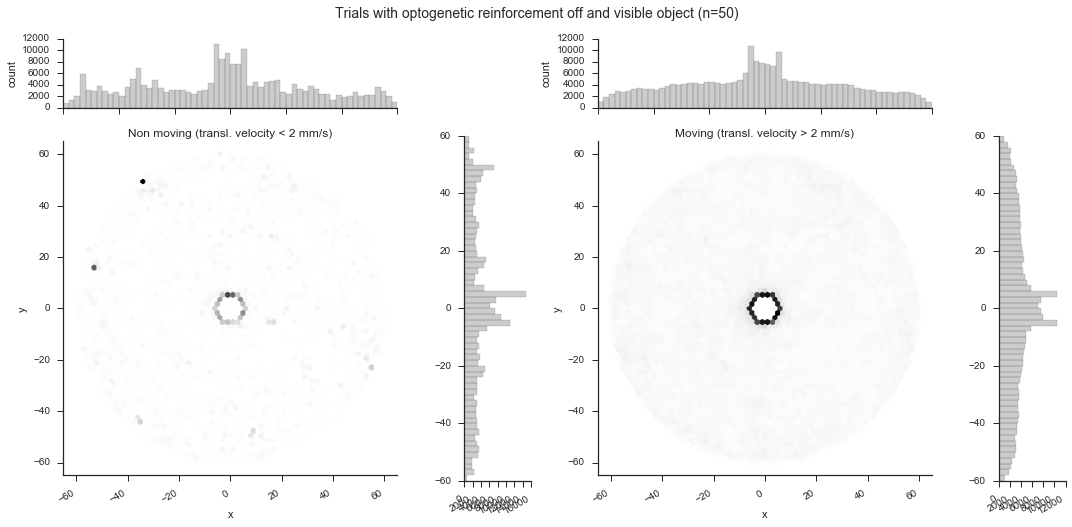

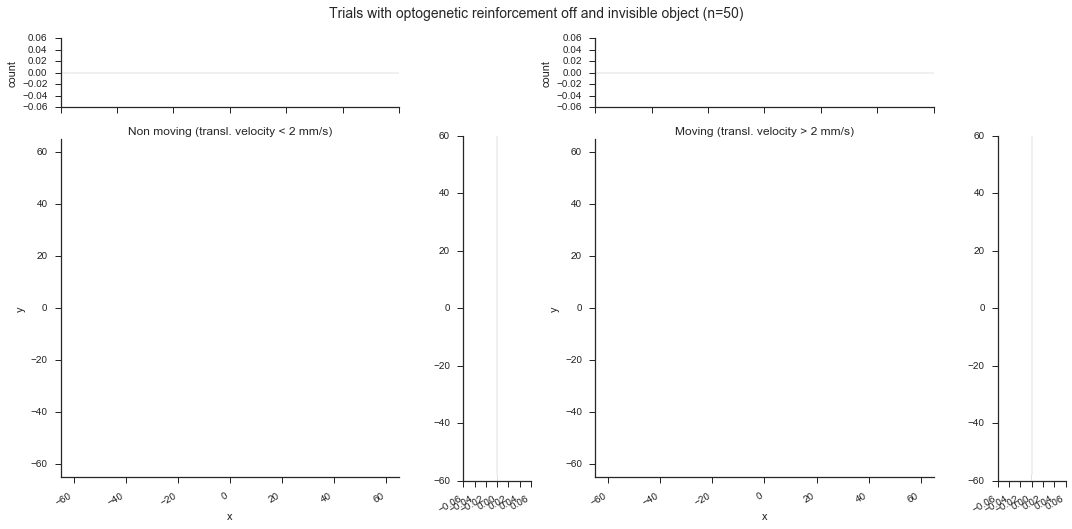

In [11]:
# make fly summary plot of residency:
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

nTrials = (nTrialsNR,nTrialsR)

for indcond, condition in enumerate(['on','off']):
    for indcond2, condition2 in enumerate(['visible','invisible']):
        querystring = '(reinforcement == "' + condition + '") & (trialtype == "'+condition2+'")'
        try:
            xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
            yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
            movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')
            vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()

            movingall = vT>vTransTH

            # make plot
            noNans = ~np.isnan(xPosMAall)
            hexplotfig = residencyWithHistograms_splitOnWalking(
                xPosMAall[noNans], yPosMAall[noNans], movingall[noNans], arenaRad, numBins, vTransTH,
                'Trials with optogenetic reinforcement ' + condition + ' and '+condition2+' object (n=' + str(nTrials[indcond]) + ')')

            try:
                mkdir(analysisDir + 'residencyPlots/')
            except:
                print('Plot directory already exists')
            hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]+'_rZones' + condition
                     + '_'+condition2+'Object'+'_residencyMA_splitonwaling_n'+ str(len(flyIDs)) +'.pdf', format='pdf')
        except ValueError:
            print('Condition was not tested.')

### 1D (radial) residency

Plot directory already exists


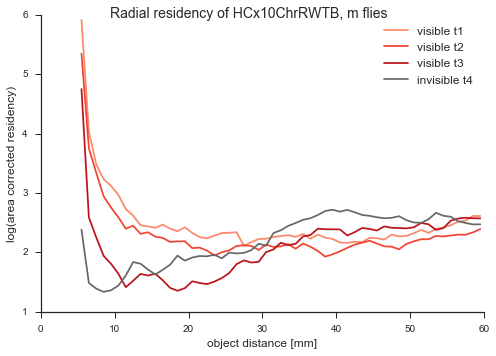

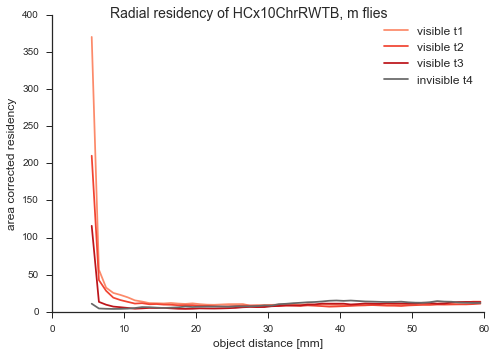

In [12]:
movementFilter = 'moving > 0'
numBins = 55
histRange = (5,arenaRad)

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')

# log residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
                               visibilityState, numBins, histRange,1, True)
myAxisTheme(radResPlt)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidency_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

# linear residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, keyind_xPos, keyind_yPos, movementFilter,
                               visibilityState, numBins, histRange,1, False)
myAxisTheme(radResPlt)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidency_lin_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 1D (radial) residency plot with variance measure based on single fly counts

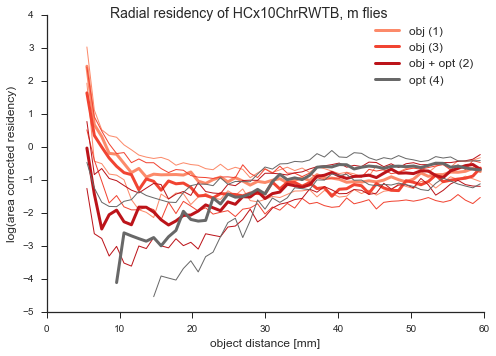

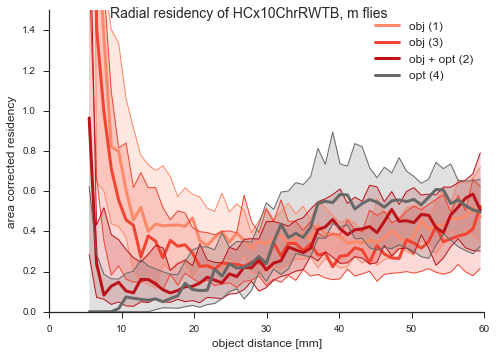

In [13]:
movementFilter = 'moving > 0'
numBins = 55
histRange = (5,arenaRad)
varStyle = 'iqr' #'std', 'iqr' 'dotplot'
fill = False

# log residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidencyWithVar_df(radResPlt, FOAllFlies_df, flyIDs, keyind_xPos, keyind_yPos, movementFilter,
                                      visibilityState, numBins, histRange, 1, True, varStyle, fill, trialName)
myAxisTheme(radResPlt)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidencyVar_'+varStyle+'_log_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

# linear residency
radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)

radResPlt = oneDimResidencyWithVar_df(radResPlt, FOAllFlies_df, flyIDs, keyind_xPos, keyind_yPos, movementFilter,
                                      visibilityState, numBins, histRange, 1, False, varStyle, True, trialName)
myAxisTheme(radResPlt)
radResPlt.set_ylim(0,1.5)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

#### Compute summary statistic: mean rel. residency at outermost 1 cm ring of optogenetic reinforcement

In [35]:
def oneDimResidencyBoxPlot_df(trial,cond,FODataframe, flyIDs, keyind_xPos, keyind_yPos, movementFilter, distRange):
    
    boxplotData = []
    
    # normalisation factor for cirle area rings
    areaNormA = np.square(distRange)*np.pi
    areaNorm = areaNormA[1]-areaNormA[0]

    for fly in range(numFlies):
        querystring = '(trialtype=="'+cond+'")&(trial=='+str(trial+1)+')&('+movementFilter\
            +')&(flyID=="'+flyIDs[fly]+'")&(objectDistance >'+str(distRange[0])+')&(objectDistance <='+str(distRange[1])+')'
                                                                                                                      
        xPosRing = np.asarray(FODataframe.query(querystring).iloc[:, keyind_xPos:keyind_xPos+1]).squeeze()

        try:
            boxplotData.append(len(xPosRing)/areaNorm)
        except TypeError:
            boxplotData.append(0)
            
    return boxplotData                                                                                                         

In [36]:
rZone_rOuter

40

In [37]:
# colormap for trials (visible object trials in colour, invisible object trials in grey shades)
numInvTrials = sum(['invisible' in visibilityState[trial] for trial in range(len(visibilityState))])
numVisTrials = len(visibilityState)-numInvTrials

visTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numVisTrials), cmap='Reds')
invTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numInvTrials), cmap='Greys')
trialCMap = [visTrialCMap.to_rgba(visTrial) for visTrial in range(numVisTrials)]
[trialCMap.append(invTrialCMap.to_rgba(invTrial)) for invTrial in range(numInvTrials)]

[None]

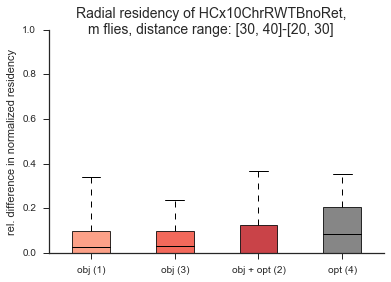

In [38]:
trials = range(4)
distRange = [rZone_rOuter-10,rZone_rOuter]
normRange = [rZone_rOuter-20,rZone_rOuter-10]
allBoxplotData = []

for trial in trials:
    boxplotDataRaw = oneDimResidencyBoxPlot_df(trial,visibilityState[trial],FOAllFlies_df,flyIDs,
                                            keyind_xPos,keyind_yPos, movementFilter, distRange)
    boxplotDataNorm = oneDimResidencyBoxPlot_df(trial,visibilityState[trial],FOAllFlies_df,flyIDs,
                                            keyind_xPos,keyind_yPos, movementFilter, normRange)
    boxplotData = np.asarray(boxplotDataRaw)-np.asarray(boxplotDataNorm)
    allBoxplotData.append(boxplotData[~np.isnan(boxplotData)])

bpFig = plt.figure(figsize=(6,4))
bpPlt = bpFig.add_subplot(1,1,1)
bp = bpPlt.boxplot(allBoxplotData,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

for ind,box in enumerate(bp['boxes']):
    plt.setp(box, alpha=0.8,
             linewidth=1, 
             facecolor=trialCMap[ind][:-1])
    
plt.xticks(range(1,5),trialName)
bpPlt.set_ylim((0,1))
bpPlt.set_ylabel('rel. difference in normalized residency')
myAxisTheme(bpPlt)

bpFig.suptitle('Radial residency of '+genotype+',\n'+flyIDs[0][0]+' flies, distance range: '+str(distRange)+'-'+str(normRange),fontsize=14)

bpFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
              + '_radResidencyBoxplot_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

np.savetxt(analysisDir+'residencyPlots/'+genotype+'_'+flyIDs[0][0]
           +'_radResidencyBoxplotData_n'+ str(len(flyIDs)) +'.csv', allBoxplotData, delimiter=',')

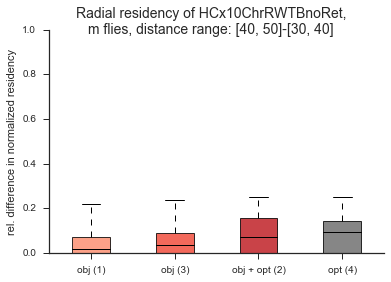

In [39]:
trials = range(4)
distRange = [rZone_rOuter,rZone_rOuter+10]
normRange = [rZone_rOuter-10,rZone_rOuter]
allBoxplotData = []

for trial in trials:
    boxplotDataRaw = oneDimResidencyBoxPlot_df(trial,visibilityState[trial],FOAllFlies_df,flyIDs,
                                            keyind_xPos,keyind_yPos, movementFilter, distRange)
    boxplotDataNorm = oneDimResidencyBoxPlot_df(trial,visibilityState[trial],FOAllFlies_df,flyIDs,
                                            keyind_xPos,keyind_yPos, movementFilter, normRange)
    boxplotData = np.asarray(boxplotDataRaw)-np.asarray(boxplotDataNorm)
    allBoxplotData.append(boxplotData[~np.isnan(boxplotData)])
    

# colormap for trials (visible object trials in colour, invisible object trials in grey shades)
numInvTrials = sum(['invisible' in visibilityState[trial] for trial in range(len(visibilityState))])
numVisTrials = len(visibilityState)-numInvTrials

visTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numVisTrials), cmap='Reds')
invTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numInvTrials), cmap='Greys')
trialCMap = [visTrialCMap.to_rgba(visTrial) for visTrial in range(numVisTrials)]
[trialCMap.append(invTrialCMap.to_rgba(invTrial)) for invTrial in range(numInvTrials)]

bpFig = plt.figure(figsize=(6,4))
bpPlt = bpFig.add_subplot(1,1,1)
bp = bpPlt.boxplot(allBoxplotData,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

for ind,box in enumerate(bp['boxes']):
    plt.setp(box, alpha=0.8,
             linewidth=1, 
             facecolor=trialCMap[ind][:-1])
    
plt.xticks(range(1,5),trialName)
bpPlt.set_ylim((0,1))
bpPlt.set_ylabel('rel. difference in normalized residency')
myAxisTheme(bpPlt)

bpFig.suptitle('Radial residency of '+genotype+',\n'+flyIDs[0][0]+' flies, distance range: '+str(distRange)+'-'+str(normRange),fontsize=14)

bpFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
              + '_radResidencyBoxplot_outside_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

np.savetxt(analysisDir+'residencyPlots/'+genotype+'_'+flyIDs[0][0]
           +'_radResidencyBoxplotData_outside_n'+ str(len(flyIDs)) +'.csv', allBoxplotData, delimiter=',')

### Boxplot of residency close to object and at zone edge

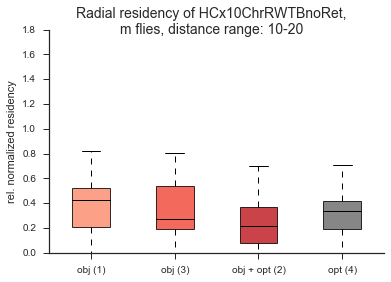

In [40]:
trials = range(4)
distRange = [10,20]
allBoxplotData = []

movementFilter = 'moving > 0'

for trial in trials:
    boxplotDataRaw = oneDimResidencyBoxPlot_df(trial,visibilityState[trial],FOAllFlies_df,flyIDs,
                                            keyind_xPos,keyind_yPos, movementFilter, distRange)
    boxplotData = np.asarray(boxplotDataRaw)
    allBoxplotData.append(boxplotData[~np.isnan(boxplotData)])
    

# colormap for trials (visible object trials in colour, invisible object trials in grey shades)
numInvTrials = sum(['invisible' in visibilityState[trial] for trial in range(len(visibilityState))])
numVisTrials = len(visibilityState)-numInvTrials

visTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numVisTrials), cmap='Reds')
invTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=numInvTrials), cmap='Greys')
trialCMap = [visTrialCMap.to_rgba(visTrial) for visTrial in range(numVisTrials)]
[trialCMap.append(invTrialCMap.to_rgba(invTrial)) for invTrial in range(numInvTrials)]

bpFig = plt.figure(figsize=(6,4))
bpPlt = bpFig.add_subplot(1,1,1)
bp = bpPlt.boxplot(allBoxplotData,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

for ind,box in enumerate(bp['boxes']):
    plt.setp(box, alpha=0.8, 
             linewidth=1, 
             facecolor=trialCMap[ind][:-1])
    
plt.xticks(range(1,5),trialName)
#bpPlt.set_ylim((0,1))
bpPlt.set_ylabel('rel. normalized residency')
myAxisTheme(bpPlt)

bpFig.suptitle('Radial residency of '+genotype+',\n'+flyIDs[0][0]+' flies, distance range: '+str(distRange[0])+'-'+str(distRange[1]),fontsize=14)

bpFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
              + '_radResidencyBoxplot_'+str(distRange[1])+'mmAroundLM_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

np.savetxt(analysisDir+'residencyPlots/'+genotype+'_'+flyIDs[0][0]
           +'_radResidencyBoxplotData_'+str(distRange[1])+'mmAroundLM_n'+ str(len(flyIDs)) +'.csv', allBoxplotData, delimiter=',')

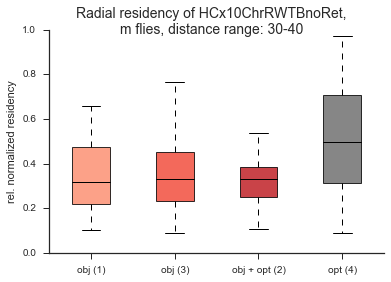

In [41]:
trials = range(4)
distRange = [rZone_rOuter-10, rZone_rOuter]
allBoxplotData = []

movementFilter = 'moving > 0'

for trial in trials:
    boxplotDataRaw = oneDimResidencyBoxPlot_df(trial,visibilityState[trial],FOAllFlies_df,flyIDs,
                                            keyind_xPos,keyind_yPos, movementFilter, distRange)
    boxplotData = np.asarray(boxplotDataRaw)
    allBoxplotData.append(boxplotData[~np.isnan(boxplotData)])

bpFig = plt.figure(figsize=(6,4))
bpPlt = bpFig.add_subplot(1,1,1)
bp = bpPlt.boxplot(allBoxplotData,patch_artist=True)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['medians'], color='black')
plt.setp(bp['fliers'], color='black', marker='+')

for ind,box in enumerate(bp['boxes']):
    plt.setp(box, alpha=0.8, 
             linewidth=1, 
             facecolor=trialCMap[ind][:-1])
    
plt.xticks(range(1,5),trialName)
#bpPlt.set_ylim((0,1))
bpPlt.set_ylabel('rel. normalized residency')
myAxisTheme(bpPlt)

bpFig.suptitle('Radial residency of '+genotype+',\n'+flyIDs[0][0]+' flies, distance range: '+str(distRange[0])+'-'+str(distRange[1]),fontsize=14)

bpFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
              + '_radResidencyBoxplot_'+str(rZone_rOuter-distRange[0])+'mmfromEdge_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

np.savetxt(analysisDir+'residencyPlots/'+genotype+'_'+flyIDs[0][0]
           +'_radResidencyBoxplotData_'+str(rZone_rOuter-distRange[0])+'mmfromEdge_n'+ str(len(flyIDs)) +'.csv', allBoxplotData, delimiter=',')

## Count number of visits (enter radius around landmark)

/Users/hannah/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Analysis directory already exists.


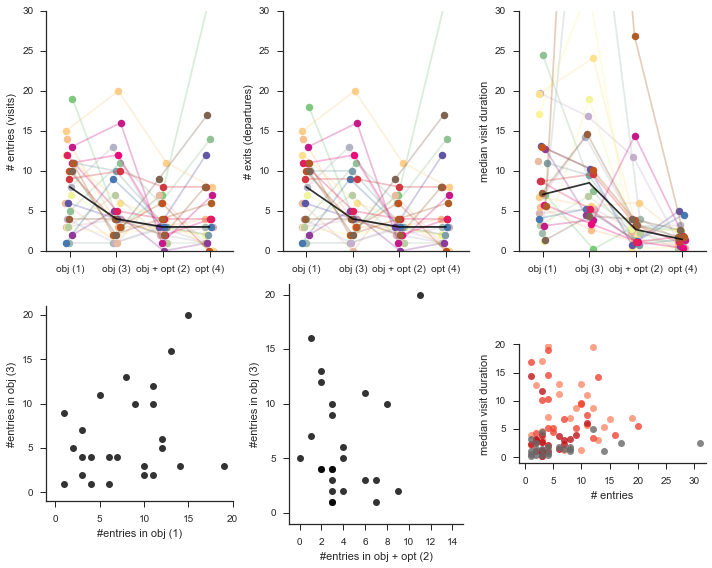

In [10]:
visitRad = 20
numtrials = 4

entriesYlim = 30

numEntries = np.zeros((numFlies,numtrials))
numExits = np.zeros((numFlies,numtrials))
lengthVisit = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

visitFig = plt.figure(figsize=(10,8))

numEntryPlt = visitFig.add_subplot(231)
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
numExitPlt = visitFig.add_subplot(232)
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
meanVisitPlt = visitFig.add_subplot(233)
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        entries, exits, visitDuration, entryTime, exitTime = countVisits_df(visitRad,flyIDs[fly],trial+1,FOAllFlies_df,keyind_xPos,keyind_yPos)
        numEntry = sum(entries)
        numExit = sum(exits)
        
        numEntries[fly,trial] = numEntry
        numExits[fly,trial] = numExit
        lengthVisit[fly,trial] = np.nanmedian(visitDuration)

        numEntryPlt.plot(trial+1+tJitter,numEntry,'.',markersize=15,color=flyCMap.to_rgba(fly))
        numExitPlt.plot(trial+1+tJitter,numExit,'.',markersize=15,color=flyCMap.to_rgba(fly))
        meanVisitPlt.plot(trial+1+tJitter,np.nanmedian(visitDuration),'.',markersize=15,color=flyCMap.to_rgba(fly))
        
    numEntryPlt.plot(range(1,numtrials+1)+jitter[fly,:],numEntries[fly,:],
                     '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    numExitPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,numExits[fly,:],'-',
                    markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    meanVisitPlt.plot(range(1,numtrials+1)+jitter[fly,:],lengthVisit[fly,:],'-',
                      markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)

#plot average response
numEntryPlt.plot(range(1,5),np.nanmedian(numEntries,axis=0),color='k',alpha=0.8)
numExitPlt.plot(range(1,5),np.nanmedian(numExits,axis=0),color='k',alpha=0.8)
meanVisitPlt.plot(range(1,5),np.nanmedian(lengthVisit,axis=0),color='k',alpha=0.8)

numEntryPlt.set_ylabel('# entries (visits)')
numEntryPlt.set_ylim(0,entriesYlim)
numEntryPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(numEntryPlt)

numExitPlt.set_ylabel('# exits (departures)')
numExitPlt.set_ylim(0,entriesYlim)
numExitPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(numExitPlt)

meanVisitPlt.set_ylabel('median visit duration')
meanVisitPlt.set_ylim(0,entriesYlim)
meanVisitPlt.set_xlim(0.5,numtrials+0.5)
myAxisTheme(meanVisitPlt)

#correlations
prepostPlt = visitFig.add_subplot(234)
prepostPlt.plot(numEntries[:,0],numEntries[:,1],'o', color='k',alpha=0.8)
prepostPlt.set_xlim(-1,np.max(numEntries[:,0])+1)
prepostPlt.set_ylim(-1,np.max(numEntries[:,1])+1)
prepostPlt.set_aspect('equal')
prepostPlt.set_xlabel('#entries in ' + trialName[0]); prepostPlt.set_ylabel('#entries in ' + trialName[1])
myAxisTheme(prepostPlt)

trainpostPlt = visitFig.add_subplot(235)
trainpostPlt.plot(numEntries[:,2],numEntries[:,1],'o', color='k',alpha=0.8)
trainpostPlt.set_xlim(-1,max(15, np.max(numEntries[:,2])+1))
trainpostPlt.set_ylim(-1,np.max(numEntries[:,1])+1)
trainpostPlt.set_aspect('equal')
trainpostPlt.set_xlabel('#entries in ' + trialName[2]); trainpostPlt.set_ylabel('#entries in ' + trialName[1])
myAxisTheme(trainpostPlt)

entryLengthPlt = visitFig.add_subplot(236)
visTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=3), cmap='Reds')
invTrialCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-2, vmax=1), cmap='Greys')
trialCMap = [visTrialCMap.to_rgba(visTrial) for visTrial in range(3)]
[trialCMap.append(invTrialCMap.to_rgba(invTrial)) for invTrial in range(1)]

for trial in range(4):
    entryLengthPlt.plot(numEntries[:,trial],lengthVisit[:,trial],'o', color=trialCMap[trial],alpha=0.8)

entryLengthPlt.set_xlim(-1,np.max(numEntries)+1)
entryLengthPlt.set_ylim(-1,20)
entryLengthPlt.set_xlabel('# entries')
entryLengthPlt.set_ylabel('median visit duration')
entryLengthPlt.set_aspect('equal')
myAxisTheme(entryLengthPlt)

visitFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'visitAnalysis' + sep)
except OSError:
    print('Analysis directory already exists.')

visitFig.savefig(analysisDir + 'visitAnalysis/'  + genotype
                   + '_visitsInRad'+str(visitRad)+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

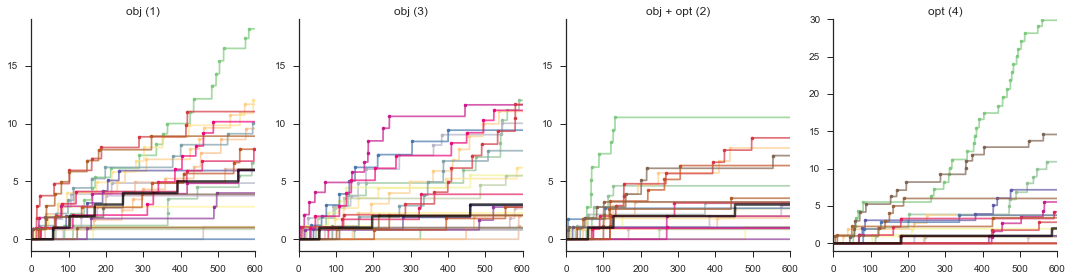

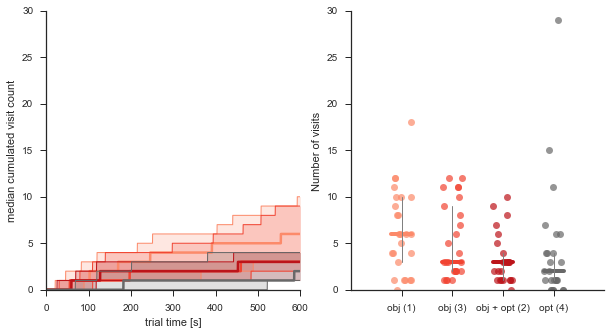

In [11]:
visitRad = 15
numtrials = 4
ymaxval = 30

visitFig = plt.figure(figsize=(15,4))
visitSummaryFig = plt.figure(figsize=(10,5))
visitSummaryPlt = visitSummaryFig.add_subplot(1,2,1)
totalVisitsPlt = visitSummaryFig.add_subplot(1,2,2)

maxVisit = 0
for trial in range(1,5):
    cumVisitPlt = visitFig.add_subplot(1,4,trial)
    
    allEntries = np.nan*np.ones((numFlies,10*60*20))
    
    # plot with individual traces
    for fly in range(numFlies):
        entries, exits, time, entryTime, exitTime = visitTime_df(visitRad,flyIDs[fly],trial,FOAllFlies_df,keyind_xPos,keyind_yPos)
        entriesCS = np.cumsum(entries + entries*np.random.uniform(-0.2, 0.2,len(entries)))
        cumVisitPlt.plot(time,entriesCS,color=flyCMap.to_rgba(fly),alpha=0.7)
        cumVisitPlt.plot(time[entries>0],entriesCS[entries>0],color=flyCMap.to_rgba(fly),marker='.',linestyle='none')
        maxVisit = max(maxVisit,sum(entries))
        
        allEntries[fly,:] = np.cumsum(entries[:10*60*20])  
    
    try:
        cumVisitPlt.plot(time,np.nanmedian(allEntries,axis=0),color='k',alpha=0.7,linewidth=2.5)
        #cumVisitPlt.plot(time,allEntries/(numFlies*np.ones(len(time))),color='k',alpha=0.7,linewidth=2.5)
    except:
        print('not enought data')
    cumVisitPlt.set_ylim(-1,min(ymaxval,maxVisit+1))
    cumVisitPlt.set_title(trialName[trial-1])
    myAxisTheme(cumVisitPlt)
    
    # summary plot
    visitSummaryPlt.plot(time, np.nanmedian(allEntries,axis=0),color=trialCMap[trial-1],alpha=1,linewidth=2.5) 
    [var1,var2] = np.nanpercentile(allEntries,[25,75],axis=0)
    visitSummaryPlt.plot(time, var1,color=trialCMap[trial-1],alpha=1,linewidth=1)
    visitSummaryPlt.plot(time, var2,color=trialCMap[trial-1],alpha=1,linewidth=1)
    visitSummaryPlt.fill_between(time, var1, var2, color=trialCMap[trial-1], alpha=0.2)
    
    # add scatterplot + median + iqr of total number of visits
    jittersize = 0.2
    y = allEntries[:,-1]
    x = trial + np.random.uniform(-jittersize,jittersize,size=len(y))
    
    totalVisitsPlt.plot(x,y,color=trialCMap[trial-1], marker='o', linestyle='none', alpha=0.7)
    totalVisitsPlt.plot([trial-jittersize,trial+jittersize], [np.nanmedian(y),np.nanmedian(y)], color=trialCMap[trial-1], linewidth=4)
    totalVisitsPlt.plot([trial,trial], np.nanpercentile(y,[25,75]), color='grey', linewidth=1)
    
    plt.xticks(range(1,5),trialName)
    

visitFig.tight_layout() 
visitFig.savefig(analysisDir + 'visitAnalysis/'  + genotype
                 + '_visitsInRad'+str(visitRad)+'_cumVisitPlt_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

visitSummaryPlt.set_xlabel('trial time [s]')
visitSummaryPlt.set_ylabel('median cumulated visit count')
visitSummaryPlt.set_ylim((0,30))
myAxisTheme(visitSummaryPlt)
    
totalVisitsPlt.set_xlim((0,trial+1))
totalVisitsPlt.set_ylim((0,30))
totalVisitsPlt.set_ylabel('Number of visits')
myAxisTheme(totalVisitsPlt)


visitSummaryFig.savefig(analysisDir + 'visitAnalysis/'  + genotype
                   + '_visitsInRad'+str(visitRad)+'_cumVisitSummaryPlt_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

## Encounter with reinforcement zone (example)

In [46]:
def plotResponse2OptogenStim(fly, trial, tSt, tEnd,maxEv,sizeScale):

    querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'

    perFlyRVal = FOAllFlies_df.query(querystring).iloc[:,keyind_event:keyind_event+1].squeeze().astype('float').values
    perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
    perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
    perFlyGamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze().astype('float').values

    time = np.linspace(0,600,len(perFlyTra))

    encounterFig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(4,2 ,width_ratios=[1,0.2])
    
    npts = len(perFlyRVal[tSt:tEnd])

    evplot = encounterFig.add_subplot(gs[0,0])
    evplot.plot(time[tSt:tEnd],perFlyRVal[tSt:tEnd],'k',alpha=0.5)
    evplot.scatter(time[tSt:tEnd],perFlyRVal[tSt:tEnd],s=sizeScale*perFlyRVal[tSt:tEnd],c=perFlyRVal[tSt:tEnd],
                   cmap='gnuplot',vmin=0,vmax=maxEv,edgecolors='face')
    evplot.set_ylabel('light stimulation level [%]')
    evplot.set_xlim(time[tSt],time[tEnd])
    myAxisTheme(evplot)

    tvplot = encounterFig.add_subplot(gs[1,0])
    tvplot.plot(time[tSt:tEnd],perFlyTra[tSt:tEnd],'k',alpha=0.5)
    tvplot.scatter(time[tSt:tEnd],perFlyTra[tSt:tEnd],s=sizeScale*perFlyRVal[tSt:tEnd],c=perFlyRVal[tSt:tEnd],
                   cmap='gnuplot',vmin=0,vmax=maxEv,edgecolors='face')
    tvplot.set_ylim(0,40)
    tvplot.set_xlim(time[tSt],time[tEnd])
    tvplot.set_ylabel('transl. velocity [mm/s]')
    myAxisTheme(tvplot)

    rvplot = encounterFig.add_subplot(gs[2,0])
    rvplot.plot(time[tSt:tEnd],perFlyRot[tSt:tEnd],'k',alpha=0.5)
    rvplot.scatter(time[tSt:tEnd],perFlyRot[tSt:tEnd],s=sizeScale*perFlyRVal[tSt:tEnd],c=perFlyRVal[tSt:tEnd],
                   cmap='gnuplot',vmin=0,vmax=maxEv,edgecolors='face')
    rvplot.set_ylim(-6,6)
    rvplot.set_xlim(time[tSt],time[tEnd])
    rvplot.set_ylabel('rot. velocity [deg/s]')
    myAxisTheme(rvplot)

    rhplot = encounterFig.add_subplot(gs[3,0])
    rhplot.plot(time[tSt:tEnd],perFlyGamma[tSt:tEnd],'k',alpha=0.5)
    rhplot.scatter(time[tSt:tEnd],perFlyGamma[tSt:tEnd],s=sizeScale*perFlyRVal[tSt:tEnd],c=perFlyRVal[tSt:tEnd],
                   cmap='gnuplot',vmin=0,vmax=maxEv,edgecolors='face')
    rhplot.set_ylim(0,np.pi)
    rhplot.set_xlim(time[tSt],time[tEnd])
    rhplot.set_ylabel('rel. heading [rad]')
    myAxisTheme(rhplot)

    evplot = encounterFig.add_subplot(gs[1,1])
    evplot.plot(perFlyRVal,perFlyTra,'k.',alpha=0.8)
    evplot.set_ylim(0,40)
    myAxisTheme(evplot)

    evplot = encounterFig.add_subplot(gs[2,1])
    evplot.plot(perFlyRVal,perFlyRot,'k.',alpha=0.8)
    evplot.set_ylim(-6,6)
    myAxisTheme(evplot)

    evplot = encounterFig.add_subplot(gs[3,1])
    evplot.plot(perFlyRVal,perFlyGamma,'k.',alpha=0.8)
    evplot.set_ylim(0,np.pi)
    evplot.set_xlabel('red LED [%]')
    myAxisTheme(evplot)
    
    return encounterFig

In [47]:
rZone_max

30

Analysis directory already exists.


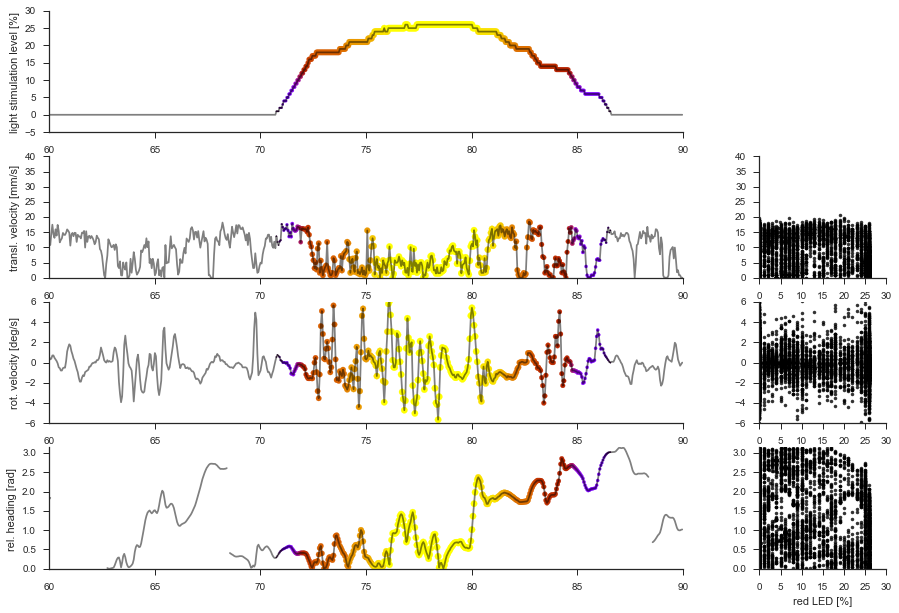

In [48]:
fly = 4
trial = 2

tSt = 20*60
tEnd = tSt+ 20*30

maxEv = rZone_max-5
sizeScale = 40.0/maxEv

encounterFig = plotResponse2OptogenStim(fly, trial, tSt, tEnd,maxEv,sizeScale)

try:
    mkdir(analysisDir + sep + 'reinforcementEffect' + sep)
except OSError:
    print('Analysis directory already exists.')

encounterFig.savefig(analysisDir + 'reinforcementEffect'+ sep + genotype + '_fly' + str(fly) + '_trial' + str(trial)
                   + 'ResponseInZone_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

Analysis directory already exists.


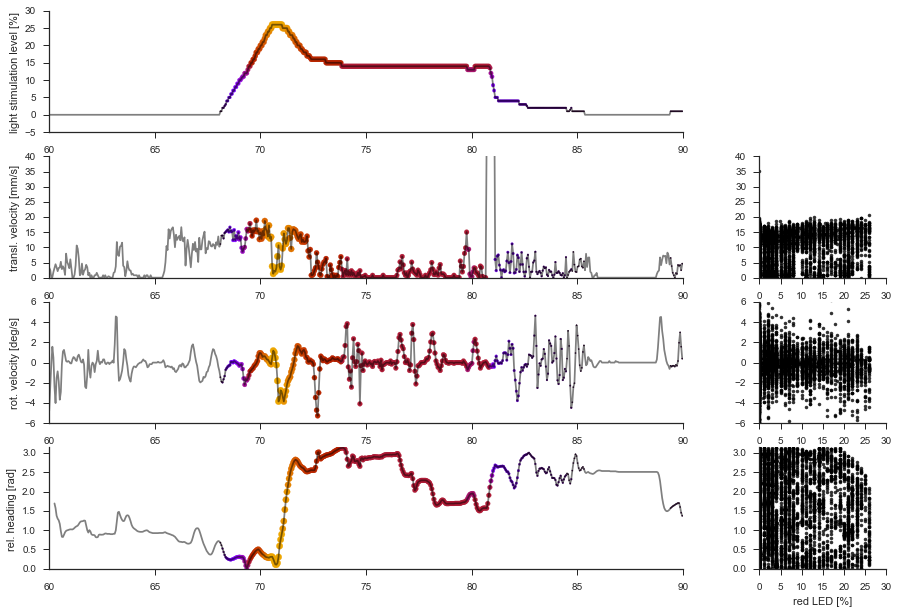

In [49]:
fly = 4
trial = 3

tSt = 20*60
tEnd = tSt+ 20*30

maxEv = rZone_max

encounterFig = plotResponse2OptogenStim(fly, trial, tSt, tEnd,maxEv,sizeScale)

try:
    mkdir(analysisDir + sep + 'reinforcementEffect' + sep)
except OSError:
    print('Analysis directory already exists.')

encounterFig.savefig(analysisDir + 'reinforcementEffect'+ sep + genotype + '_fly' + str(fly) + '_trial' + str(trial)
                   + 'ResponseInZone_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

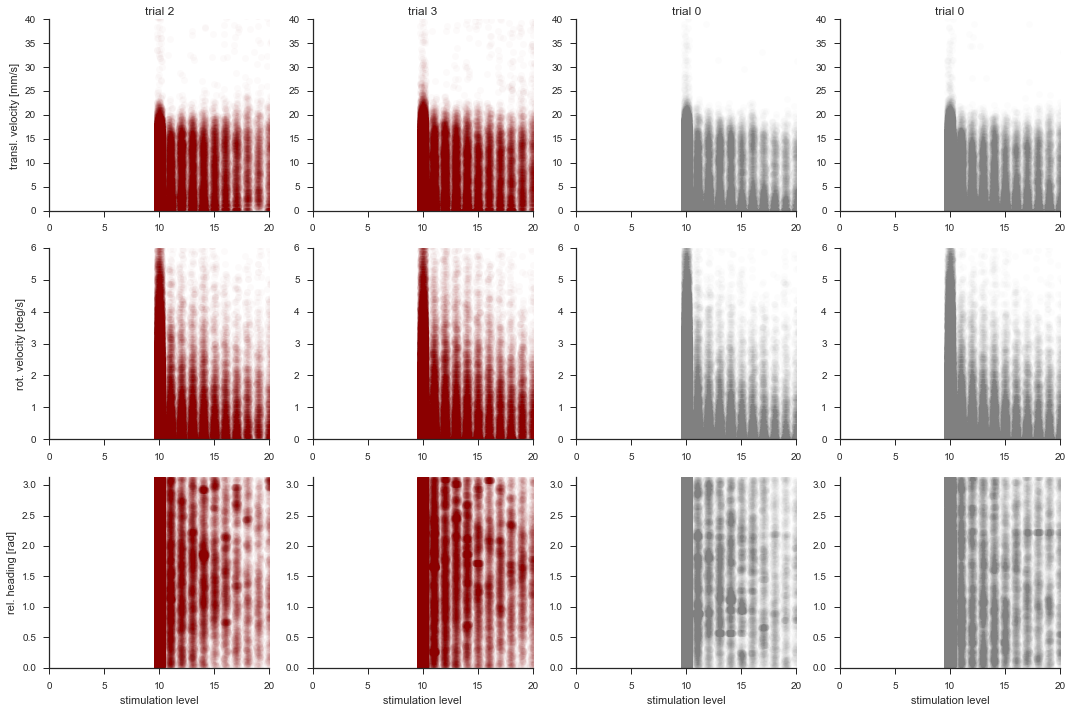

In [48]:
trialList = [2,3,0,0]
eventTList = [2,3,2,3]
tCol = ['darkred','darkred','grey','grey']
aval = 0.02

maxStimLevel = rZone_max-10

encounterFig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,len(trialList)) #,width_ratios=[1,1])

for tInd in range(len(trialList)):
    trial = trialList[tInd]
    
    querystring = '(trial == ' + str(eventTList[tInd]+1) + ')'
    perFlyRVal = FOAllFlies_df.query(querystring).iloc[:,keyind_event:keyind_event+1].squeeze().astype('float').values
    
    perFlyRVal = perFlyRVal+np.random.uniform(-0.25, 0.25,np.size(perFlyRVal))
    
    querystring = '(trial == ' + str(trial+1) + ')'
    perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
    perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
    perFlyGamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze().astype('float').values

    try:
        tvplot = encounterFig.add_subplot(gs[0,tInd])
        tvplot.plot(perFlyRVal,perFlyTra,'o',color=tCol[tInd], alpha=aval)
        tvplot.set_ylim(0,40)
        tvplot.set_xlim(0,maxStimLevel)
        tvplot.set_title('trial '+ str(trialList[tInd]))
        myAxisTheme(tvplot)

        rvplot = encounterFig.add_subplot(gs[1,tInd])
        rvplot.plot(perFlyRVal,abs(perFlyRot),'o',color=tCol[tInd], alpha=aval)
        rvplot.set_ylim(0,6)
        rvplot.set_xlim(0,maxStimLevel)
        myAxisTheme(rvplot)

        rhplot = encounterFig.add_subplot(gs[2,tInd])
        rhplot.plot(perFlyRVal,perFlyGamma,'o',color=tCol[tInd], alpha=aval)
        rhplot.set_ylim(0,np.pi)
        rhplot.set_xlim(0,maxStimLevel)
        rhplot.set_xlabel('stimulation level')
        myAxisTheme(rhplot)
    except:
        print('measurement missing')
    
    if tInd<1:
        tvplot.set_ylabel('transl. velocity [mm/s]')
        rvplot.set_ylabel('rot. velocity [deg/s]')
        rhplot.set_ylabel('rel. heading [rad]')

encounterFig.tight_layout()

encounterFig.savefig(analysisDir + 'reinforcementEffect'+ sep + genotype
                   + '_ResponseInZone_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 2D (polar) residency: heading vs. distance

Plot directory already exists


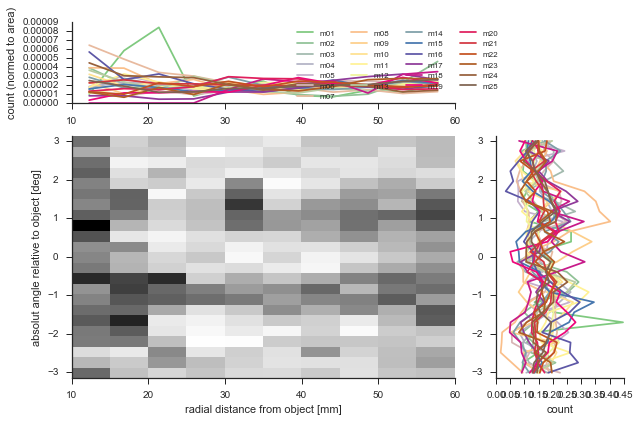

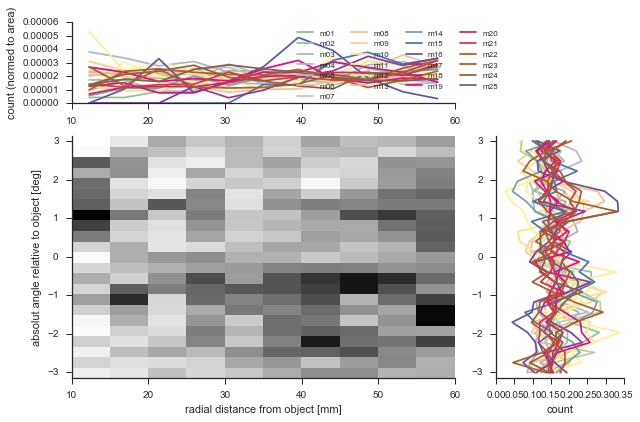

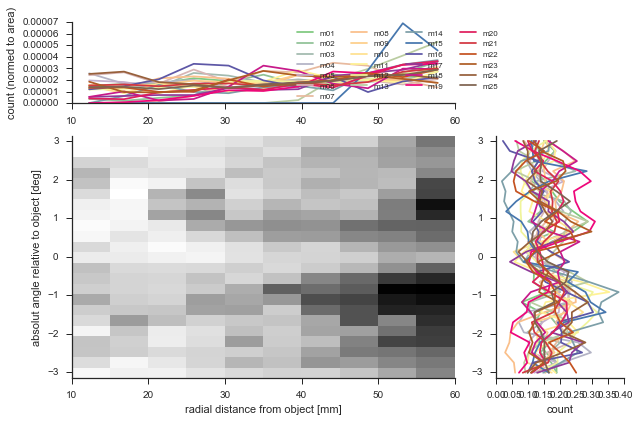

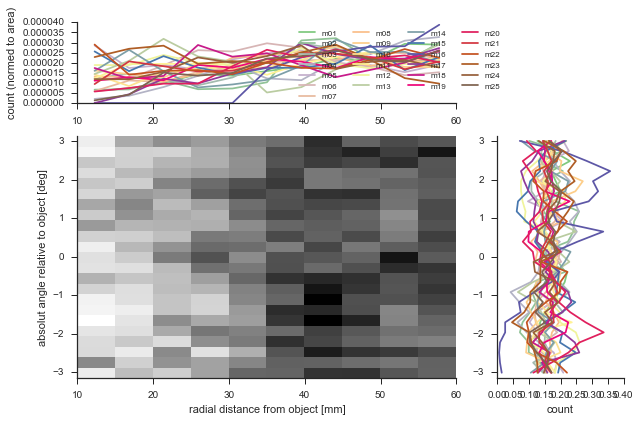

In [50]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad
minDist = 10

try:
    mkdir(analysisDir + 'headingVsDistance/')
except:
    print('Plot directory already exists')

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(visibilityState):
    querystring = '(trialtype == "'+trialtype+'") & (trial == '+str(ttind+1)+\
        ') & (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray,
                                           objDistMAall,gammaFullall)
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

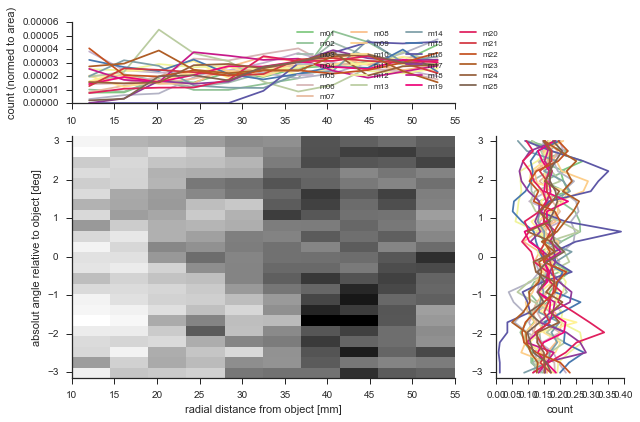

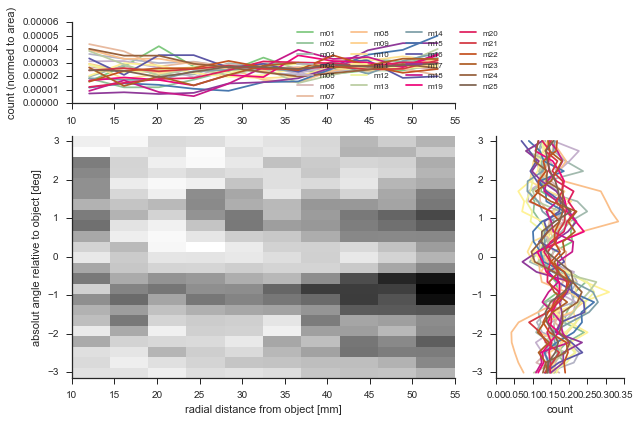

In [51]:
# plot parameter
distBins = 11
angleBins = 24
maxDist = arenaRad-5
minDist = 10

for ttind,trialtype in enumerate(list(set(visibilityState))):
    querystring = '(trialtype == "'+trialtype+'")'+\
        '& (moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<' + str(maxDist) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistMAall, _ = cartesian2polar(xPosMAall,yPosMAall)

    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,minDist,maxDist,flyIDs,flyIDallarray,
                                           objDistMAall,gammaFullall)
    
    headingDistFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_' + trialtype
                           + '_headingVsDistanceHist_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

## Polar coord maps of movement parameter

In [54]:
minDist = 6
maxDist = 56
distEdges = np.linspace(minDist, maxDist, 10)
angleEdges = np.linspace(0, np.pi, 9)
fullAngleEdges = np.linspace(-np.pi, np.pi, 18)
maxVals = (20.0,10.0, 1.5, 0.3)# (12.0,7.0, 1.0, 0.3) #

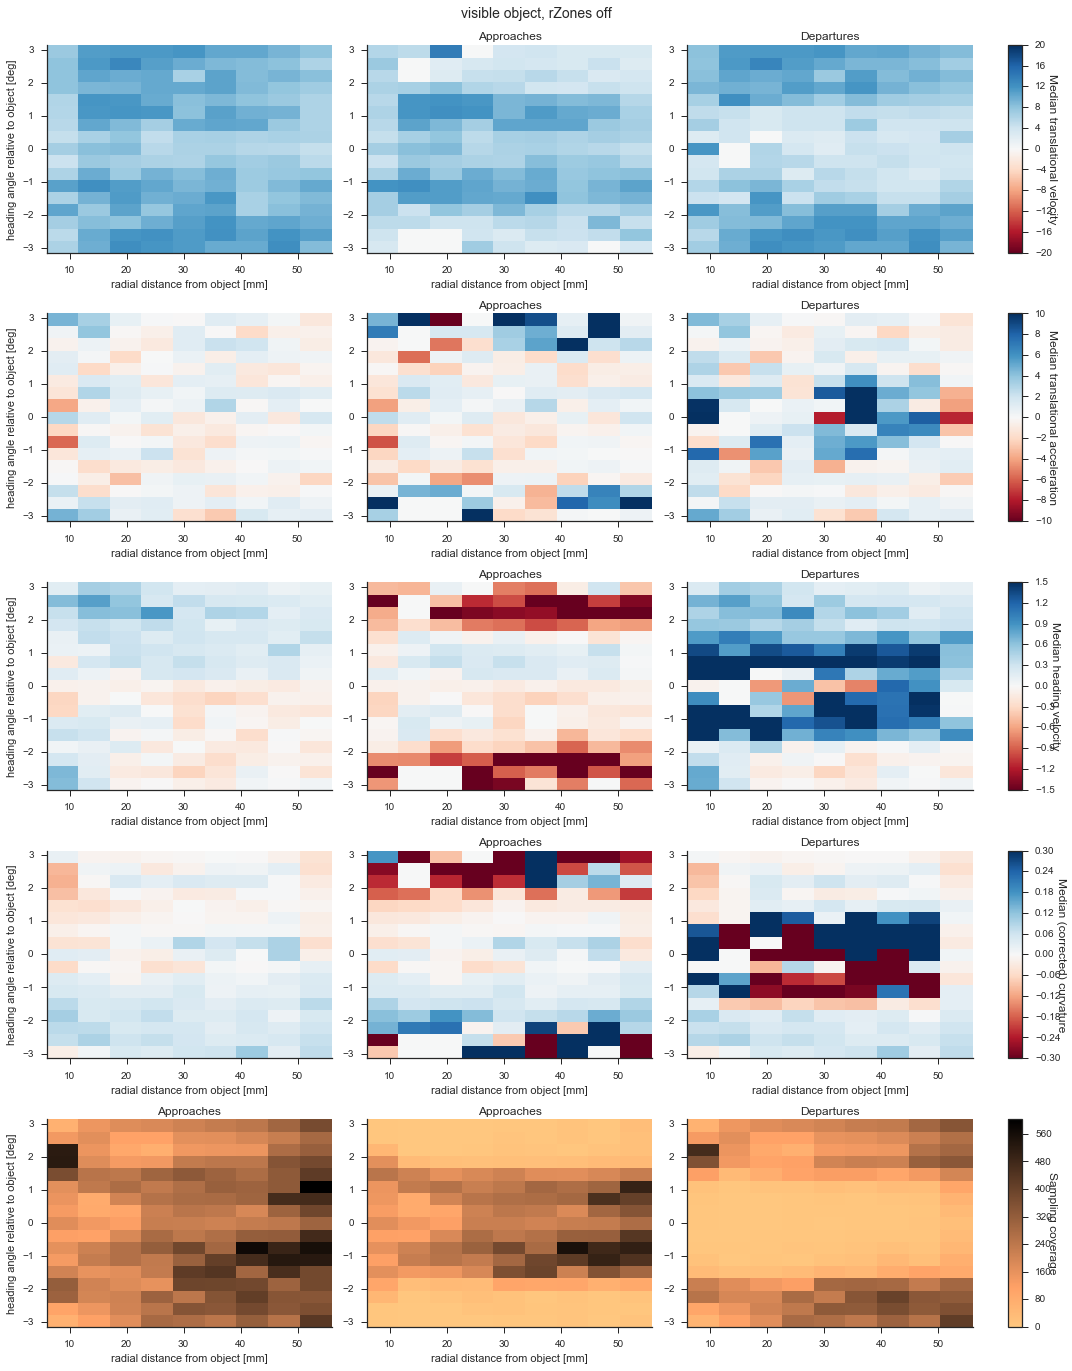

In [71]:
#for tind,trialtype in enumerate(visibilityState):
trial = 1
trialtype = 'visible'
querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

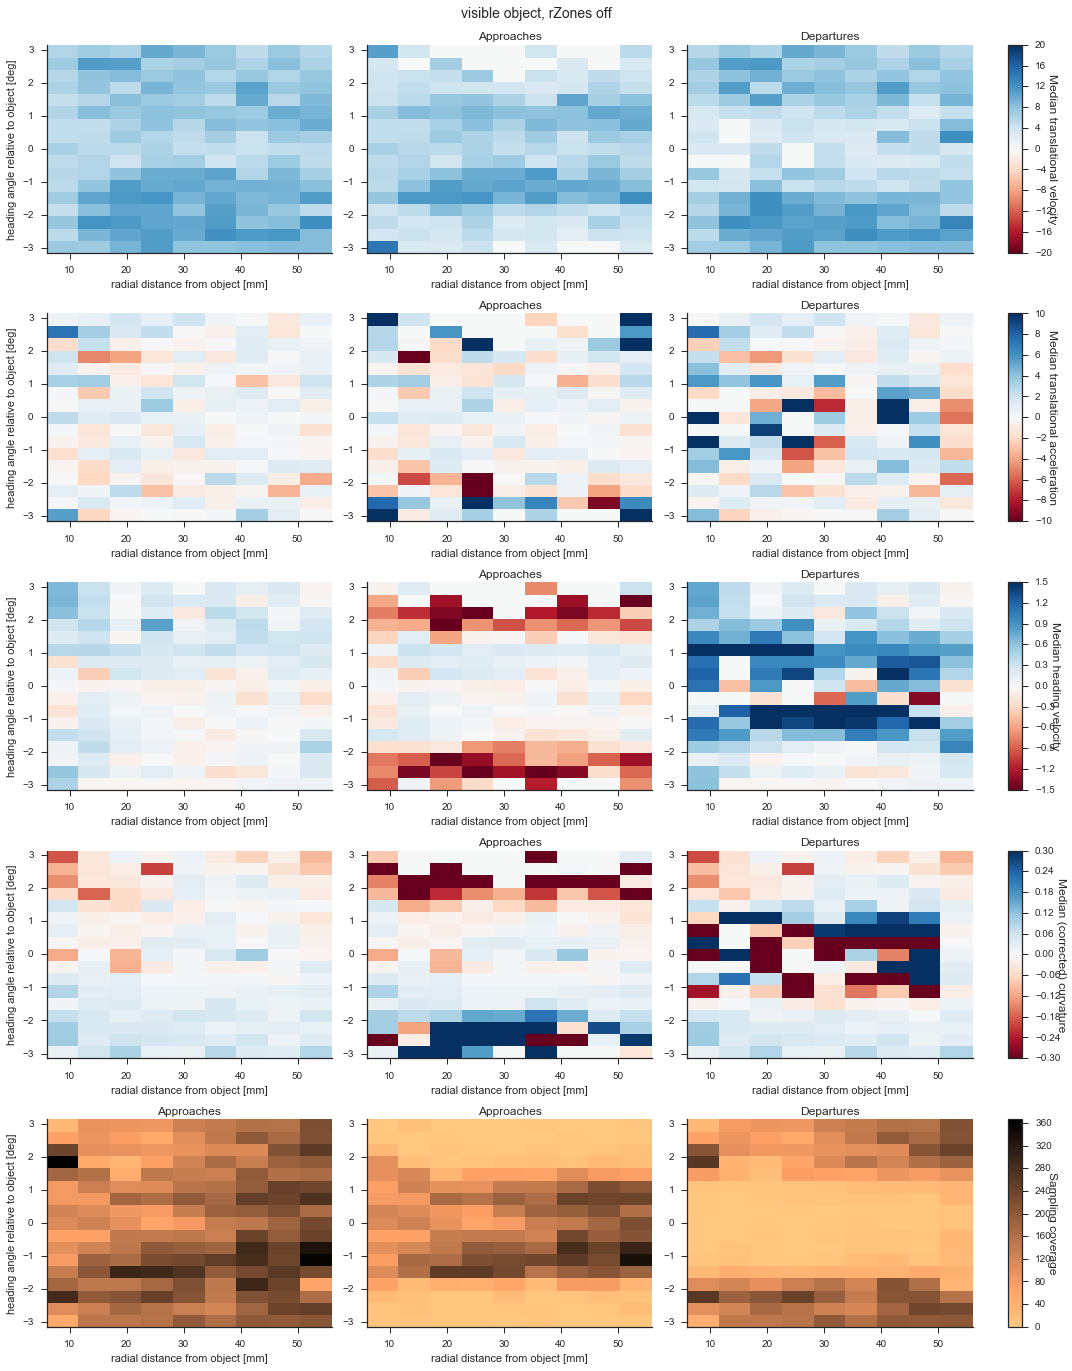

In [72]:
trialtype = 'visible'
trial = 2

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

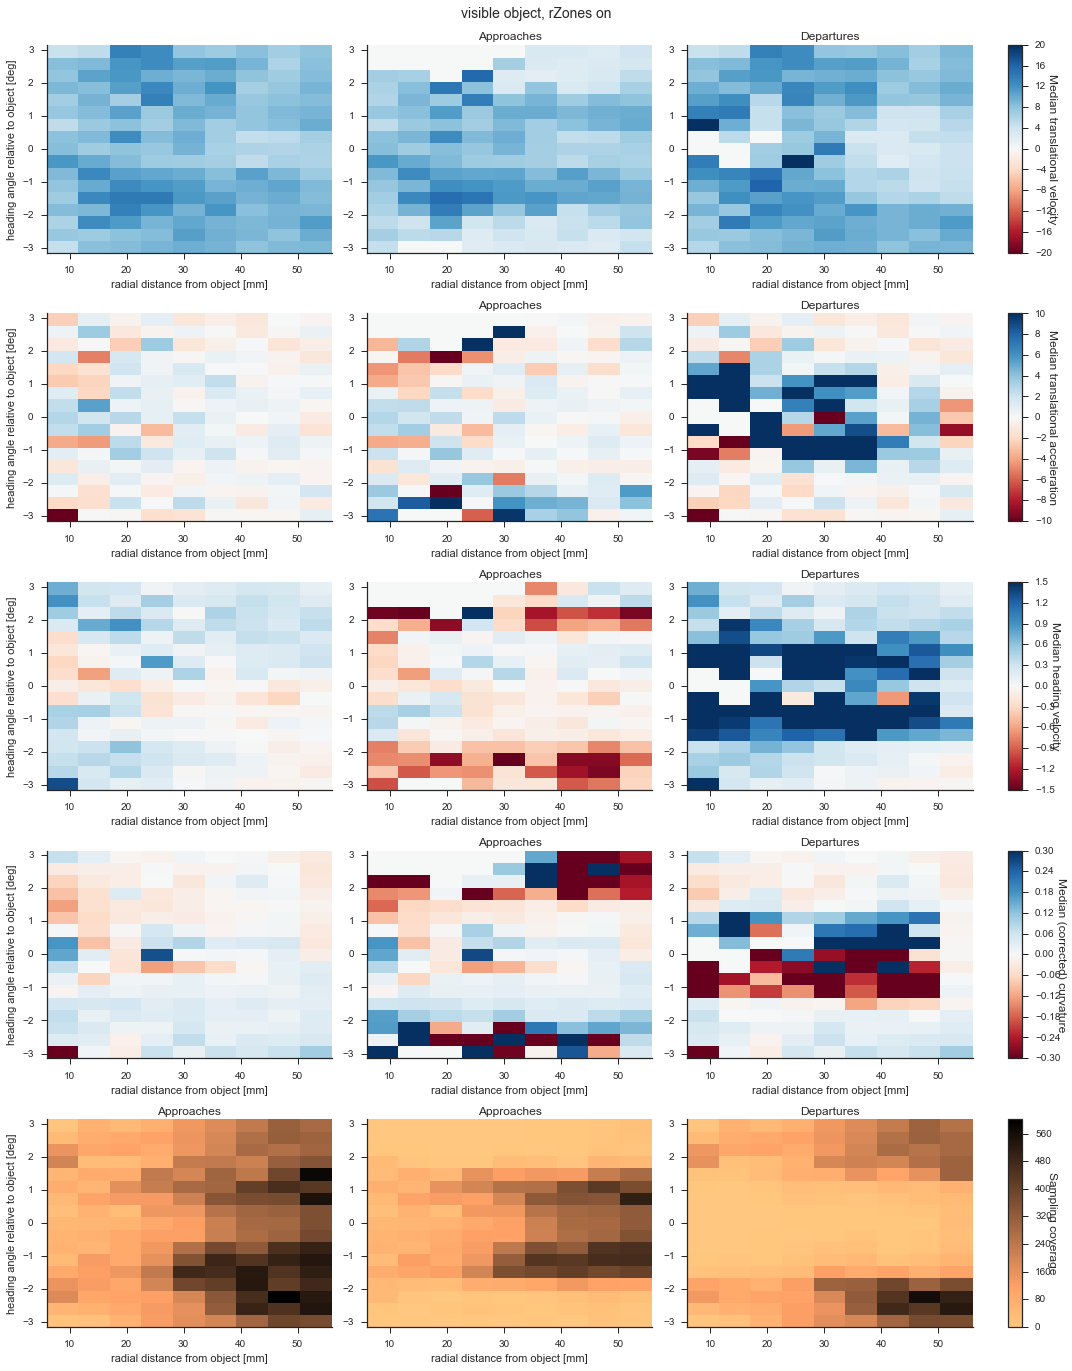

In [73]:
trialtype = 'visible'
trial = 3

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

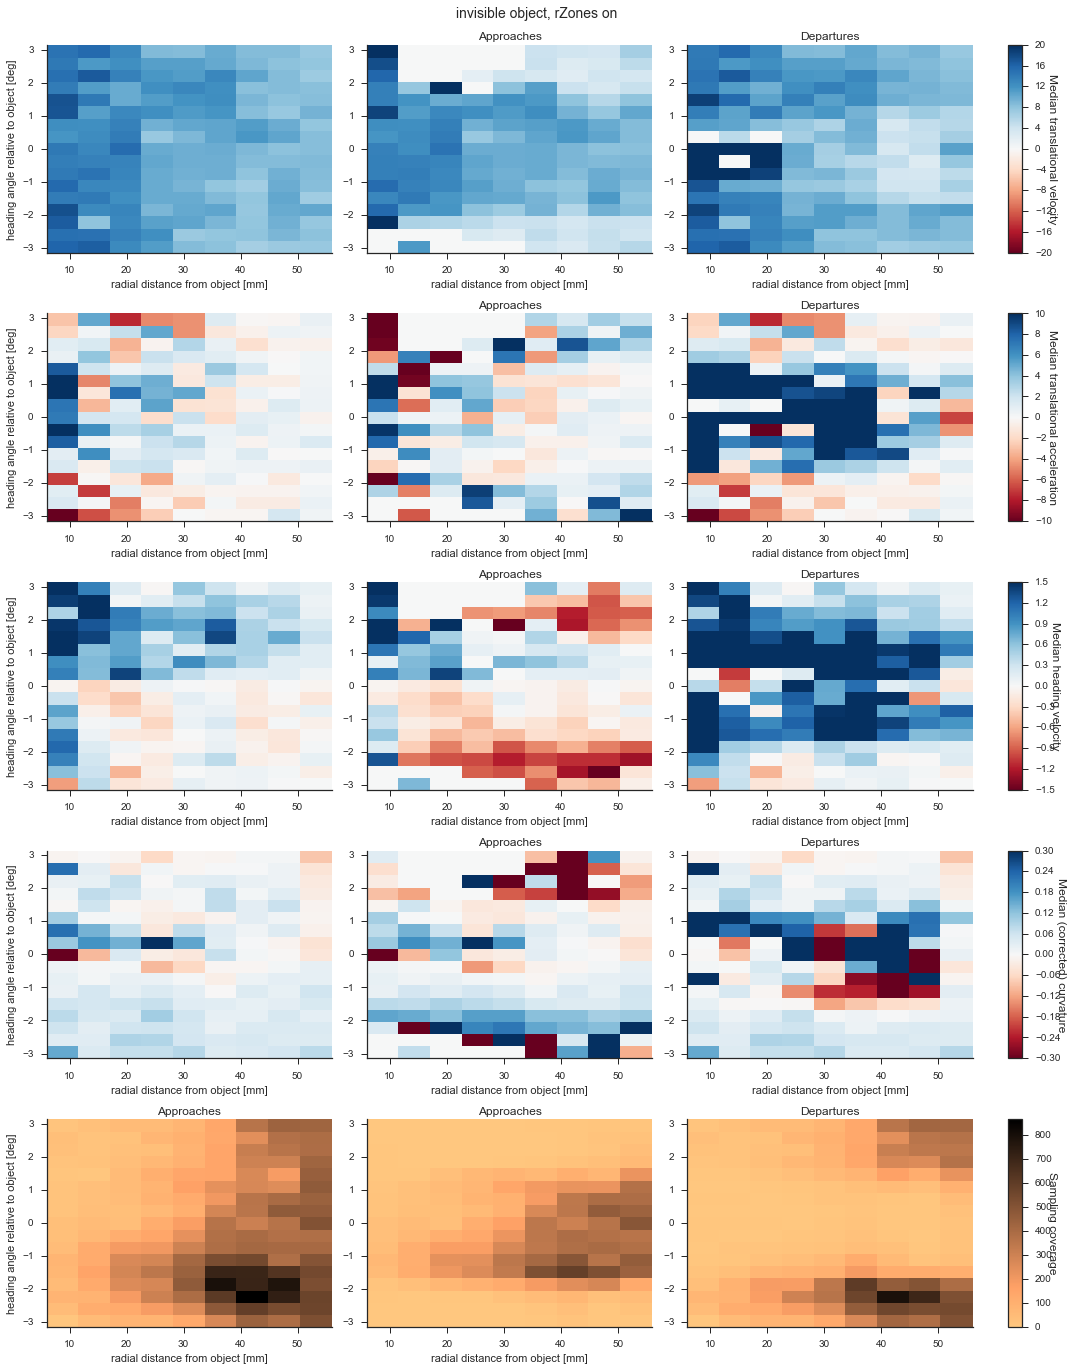

In [74]:
trialtype = 'invisible'
trial = 4

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial == '+str(trial)+')' 
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall, thetaall = cartesian2polar(xPosMAall,yPosMAall)
polarCurv, d_theta, dtheta_objDist = polarCurvature(thetaall, objDistanceall)

relPolMeanFig = plt.figure(figsize = (15,20))
relPolMeanFig = make4ValuePolCoordPlot(relPolMeanFig,objDistanceall,gammaall,gammaFullall,vT,polarCurv,
                                       d_theta, time, distEdges,fullAngleEdges,maxVals)
relPolMeanFig.tight_layout()
relPolMeanFig.tight_layout(rect=[0, 0.03, 1, 0.97])
relPolMeanFig.suptitle(trialtype + ' object, rZones ' + rZoneState[trial-1],fontsize=14)

relPolMeanFig.savefig(analysisDir + 'headingVsDistance/'+ genotype +'_'+flyIDs[0][0]+'_'+trialtype+'Objects_rZone'
                      +rZoneState[trial-1]+'_steering_headingVsDistance_trial'+ str(trial) +'_n'+ str(len(flyIDs)) +'.pdf',
                      format='pdf')

### Per-fly comparison between trials

In [53]:
rZone_rOuter

40

Analysis directory already exists.


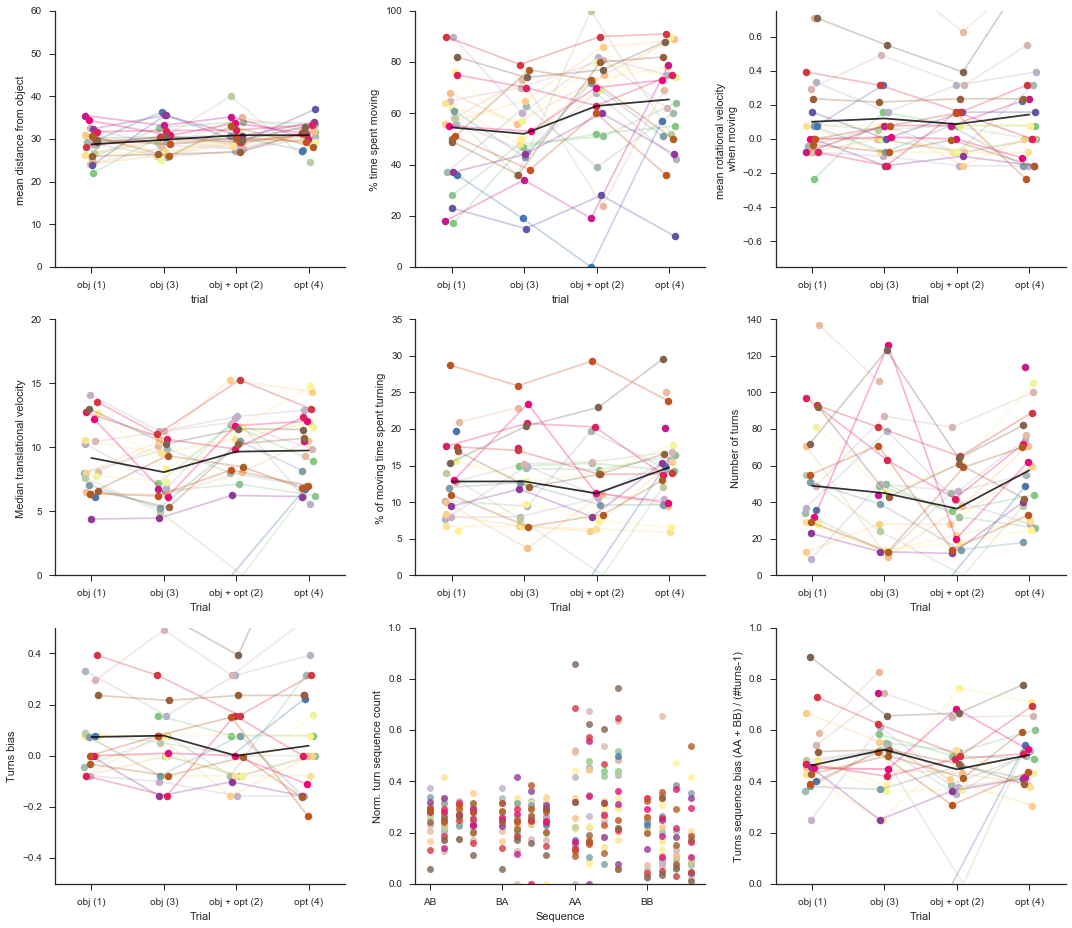

In [54]:
# make fly summary plot of residency:
arenaRad = 60
numtrials = len(visibilityState)
numVItrials = sum(['visible' in visibilityState[trial] for trial in range(len(visibilityState))])
numIVtrials = len(visibilityState)-numVItrials

minTurnDist = 5

minDist = 10 #rZone_rOuter
maxDist = rZone_rOuter#arenaRad

trialComparisonFig = plt.figure(figsize=(15,13))
gs = gridspec.GridSpec(3,3) #,width_ratios=[1,0.9])

nTrial = [nTrialsNR/2, nTrialsNR/2,nTrialsR/2, nTrialsIN]

# Top row plots: ...............................................................................................

# Plots of (a) percent of time spent moving, (b) rotational bias and (c) mean distance from object
percentMoving = np.zeros((numFlies,numtrials))
rotationBias = np.zeros((numFlies,numtrials))
meanObjDist = np.zeros((numFlies,numtrials))
jitter = np.zeros((numFlies,numtrials))

perFlyMeanDistPlt = trialComparisonFig.add_subplot(gs[0,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,1])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyRotBiasPlt = trialComparisonFig.add_subplot(gs[0,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')


for fly in range(numFlies):
    for trial in range(numtrials):

        tJitter = np.random.uniform(-0.1, 0.1)
        jitter[fly,trial] = tJitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +'")'\
                        +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int')
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                       +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')
        perFlyObjDist = FOAllFlies_df.query(querystring).iloc[:,keyind_objD:keyind_objD+1].squeeze().astype('float')
        
        if np.asarray(perFlyMoving).size ==1:
            percentMoving[fly,trial] = 100*perFlyMoving
        else:
            percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        
        rotationBias[fly,trial] = np.nanmedian(perFlyRot)
        meanObjDist[fly,trial] = np.nanmedian(perFlyObjDist)
        
        perFlyMovingPlt.plot(trial+1+tJitter,percentMoving[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))

        perFlyRotBiasPlt.plot(trial+1+tJitter,rotationBias[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        perFlyMeanDistPlt.plot(trial+1+tJitter,meanObjDist[fly,trial],'.',markersize=15,color=flyCMap.to_rgba(fly))
        
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+jitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    perFlyRotBiasPlt.plot(range(1,numtrials+1)+jitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
        
    perFlyMeanDistPlt.plot(range(1,numtrials+1)+jitter[fly,:],meanObjDist[fly,:],'-',
                         markersize=15, color=flyCMap.to_rgba(fly), alpha=0.3)
    
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,numtrials+1),np.nanmean(rotationBias,axis=0),color='k',alpha=0.8)
perFlyMeanDistPlt.plot(range(1,numtrials+1),np.nanmean(meanObjDist,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMeanDistPlt.set_ylim(0,arenaRad)
perFlyMeanDistPlt.set_xlim(0.5,numtrials+0.5)
perFlyMeanDistPlt.set_xlabel('trial')
perFlyMeanDistPlt.set_ylabel('mean distance from object')
myAxisTheme(perFlyMeanDistPlt)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('trial')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.75,0.75)
perFlyRotBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyRotBiasPlt.set_xlabel('trial')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity \n when moving')
myAxisTheme(perFlyRotBiasPlt)

# Bottom row plots: ...............................................................................................

# Only include moving flies
querystring = '(moving > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 2*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -2*np.std(vRot_filt[vRot_filt<=0])

percentMoving = np.zeros((numFlies,numtrials))
perFlyTurnTH = np.zeros((numFlies,numtrials))
perFlyNumTurn = np.zeros((numFlies,numtrials))
perFlyTurnDir = np.zeros((numFlies,numtrials))
perFlyTurnSeqBias = np.zeros((numFlies,numtrials))

randJitter = np.zeros((numFlies,numtrials))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyTurnTHPlt = trialComparisonFig.add_subplot(gs[1,1])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyNumTurnPlt = trialComparisonFig.add_subplot(gs[1,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

perFlyTurnDirPlt = trialComparisonFig.add_subplot(gs[2,0])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')
perFlyTurnSeqPlt = trialComparisonFig.add_subplot(gs[2,1])
plt.xticks([0,1,2,3],['AB','BA','AA','BB'])
perFlyTurnSeqBiasPlt = trialComparisonFig.add_subplot(gs[2,2])
plt.xticks([1,2,3,4],trialName, rotation='horizontal')

for fly in range(numFlies):
    for trial in range(numtrials):
        
        jitter = np.random.uniform(-0.1, 0.1)
        randJitter[fly,trial] = jitter
        
        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'\
                      +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        
        if perFlyMoving.size < 5:
            continue
            
        if (100.0*sum(perFlyMoving))/max(1,len(perFlyMoving)) < 30:
            percentMoving[fly,trial] = np.nan
            perFlyTurnTH[fly,trial] = np.nan
            perFlyNumTurn[fly,trial] = np.nan
            perFlyTurnDir[fly,trial] = np.nan
            perFlyTurnSeqBias[fly,trial] = np.nan
            continue

        querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                      +'& (objectDistance >='+str(minDist)+') & (objectDistance <='+str(maxDist)+')'
        perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
        
        perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')
        
        turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
        turnLoc = np.where(turnMask>0)[0]
        turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]
        turnSide = np.sign(perFlyRot[turnStart])
        
        try:
            turnSeq = np.zeros(len(turnStart)-1)
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==0.5)[0]] = 2
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-0.5)[0]] = 3
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-1.5)[0]] = 0
            turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-2.5)[0]] = 1
            
            numBin = 4
            [n,edgs] = np.histogram(turnSeq,bins=numBin)
        
        except ValueError:
            print('Not enought turns in fly' + str(fly))
            n = np.ones(numBin)*np.nan
            
        perFlyTurnTH[fly,trial] = 100.0*(sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg))/max(1,len(perFlyRot_filt))
        perFlyNumTurn[fly,trial] = len(turnStart)
        perFlyTurnDir[fly,trial] = np.nanmedian(perFlyRot)
        #abs((1.0*sum(perFlyRot_filt>turnTH_pos) - sum(perFlyRot_filt<turnTH_neg))/
        #                               max(1.0*sum(perFlyRot_filt>turnTH_pos) + sum(perFlyRot_filt<turnTH_neg),1))
        if sum(n)==0:
            perFlyTurnSeqBias[fly,trial] = np.nan
        else:
            perFlyTurnSeqBias[fly,trial] = float(sum(n[2:]))/sum(n)
        
        alphaVal = min(perFlyNumTurn[fly,trial]/3,1)
        
        percentMoving[fly,trial] = np.nanmedian(perFlyTra)
        
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnTHPlt.plot(trial+1+jitter,perFlyTurnTH[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyNumTurnPlt.plot(trial+1+jitter,perFlyNumTurn[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyTurnDirPlt.plot(trial+1+jitter,perFlyTurnDir[fly,trial],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqPlt.plot(range(numBin)+np.ones(numBin)*0.2*trial,n/(np.ones(numBin)*sum(n)),
                              marker = 'o',linestyle='none',alpha = 0.8,color = flyCMap.to_rgba(fly))
        
        perFlyTurnSeqBiasPlt.plot(trial+1+jitter,perFlyTurnSeqBias[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        
    perFlyMovingPlt.plot(range(1,numtrials+1)+randJitter[fly,:],percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)    
    perFlyTurnTHPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnTH[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyNumTurnPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyNumTurn[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnDirPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnDir[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnSeqBias[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    
#plot average response
perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyTurnTHPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnTH,axis=0),color='k',alpha=0.8)
perFlyNumTurnPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyNumTurn,axis=0),color='k',alpha=0.8)
perFlyTurnDirPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnDir,axis=0),color='k',alpha=0.8)
perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnSeqBias,axis=0),color='k',alpha=0.8)

# Beautify axes
perFlyMovingPlt.set_ylim(0,20)
perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
perFlyMovingPlt.set_xlabel('Trial')
perFlyMovingPlt.set_ylabel('Median translational velocity')
myAxisTheme(perFlyMovingPlt)

perFlyTurnTHPlt.set_ylim(0,35)
perFlyTurnTHPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnTHPlt.set_xlabel('Trial')
perFlyTurnTHPlt.set_ylabel('% of moving time spent turning')
myAxisTheme(perFlyTurnTHPlt)

perFlyNumTurnPlt.set_xlim(0.5,numtrials+0.5)
perFlyNumTurnPlt.set_xlabel('Trial')
perFlyNumTurnPlt.set_ylabel('Number of turns')
myAxisTheme(perFlyNumTurnPlt)

perFlyTurnDirPlt.set_ylim(-0.5,0.5)
perFlyTurnDirPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnDirPlt.set_xlabel('Trial')
perFlyTurnDirPlt.set_ylabel('Turns bias')
myAxisTheme(perFlyTurnDirPlt)

perFlyTurnSeqPlt.set_ylim(0,1)
perFlyTurnSeqPlt.set_xlim(-0.2,numBin-0.2)
perFlyTurnSeqPlt.set_xlabel('Sequence')
perFlyTurnSeqPlt.set_ylabel('Norm. turn sequence count')
myAxisTheme(perFlyTurnSeqPlt)

perFlyTurnSeqBiasPlt.set_ylim(0,1)
perFlyTurnSeqBiasPlt.set_xlim(0.5,numtrials+0.5)
perFlyTurnSeqBiasPlt.set_xlabel('Trial')
perFlyTurnSeqBiasPlt.set_ylabel('Turns sequence bias (AA + BB) / (#turns-1)')
myAxisTheme(perFlyTurnSeqBiasPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareAllTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir+'compareAllTrials/'+genotype+'_'+flyIDs[0][0]
                   +'_allTrials_'+str(minDist)+'-'+str(maxDist)+'_n'+str(len(flyIDs))+'.pdf', format='pdf')

In [55]:
def pltScatterMedIQR(spthandle,y,randjitter,jittersize,col,trial):
    # add scatterplot + median + iqr of total number of visits

    #x = trial + np.random.uniform(-jittersize,jittersize,size=len(y))
    x = trial + randjitter[:,trial-1]
    spthandle.plot(x,y,color=col, marker='o', linestyle='none', alpha=0.7)
    spthandle.plot([trial-jittersize,trial+jittersize], [np.nanmedian(y),np.nanmedian(y)], color='black', linewidth=4)
    spthandle.plot([trial,trial], np.nanpercentile(y,[25,75]), color='black', linewidth=1)
    
    return spthandle

In [56]:
def compareInsideOutsidePlot(trialComparisonFig):
    gs = gridspec.GridSpec(1,5)
    
    jittersize=0.1

    nTrial = [nTrialsNR/2, nTrialsNR/2,nTrialsR/2, nTrialsIN]

    # plots: ...............................................................................................
    percentMoving = np.zeros((numFlies,numtrials))
    transVelo = np.zeros((numFlies,numtrials))
    rotationBias = np.zeros((numFlies,numtrials))
    perFlyTurnTH = np.zeros((numFlies,numtrials))
    perFlyNumTurn = np.zeros((numFlies,numtrials))
    perFlyTurnSeqBias = np.zeros((numFlies,numtrials))

    randJitter = np.zeros((numFlies,numtrials))

    perFlyMovingPlt = trialComparisonFig.add_subplot(gs[0,0])
    plt.xticks([1,2,3,4],xticklabels, rotation='horizontal')
    perFlyTransPlt = trialComparisonFig.add_subplot(gs[0,1])
    plt.xticks([1,2,3,4],xticklabels, rotation='horizontal')
    perFlyRotBiasPlt = trialComparisonFig.add_subplot(gs[0,2])
    plt.xticks([1,2,3,4],xticklabels, rotation='horizontal')
    perFlyNumTurnPlt = trialComparisonFig.add_subplot(gs[0,3])
    plt.xticks([1,2,3,4],xticklabels, rotation='horizontal')
    perFlyTurnSeqBiasPlt = trialComparisonFig.add_subplot(gs[0,4])
    plt.xticks([1,2,3,4],xticklabels, rotation='horizontal')


    # Only include moving flies
    querystring = '(moving > 0)'
    vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
    time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

    # Find turnTH over all flies
    vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
    turnTH_pos = 2*np.std(vRot_filt[vRot_filt>=0])
    turnTH_neg = -2*np.std(vRot_filt[vRot_filt<=0])


    for fly in range(numFlies):
        for tind, trial in enumerate(trialIDs):

            minDist = minDists[tind]
            maxDist = maxDists[tind]

            tJitter = np.random.uniform(-jittersize, jittersize)

            jitter = np.random.uniform(-jittersize, jittersize)
            randJitter[fly,tind] = jitter

            querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                           +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
            perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')

            rotationBias[fly,tind] = np.nanmedian(abs(perFlyRot))                

            querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'\
                          +'& (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+')'
            perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')

            if (perFlyMoving.size < 5) or ((100.0*sum(perFlyMoving))/max(1,len(perFlyMoving)) < 30):
                percentMoving[fly,tind] = np.nan
                transVelo[fly,tind] = np.nan
                perFlyTurnTH[fly,tind] = np.nan
                perFlyNumTurn[fly,tind] = np.nan
                perFlyTurnSeqBias[fly,tind] = np.nan
                continue

            querystring = '(trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '") & (moving > 0)'\
                          +'& (objectDistance >='+str(minDist)+') & (objectDistance <='+str(maxDist)+')'
            perFlyTra = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze().astype('float').values
            perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values

            perFlyRot_filt = np.convolve(perFlyRot, np.ones((5,))/5, mode='same')

            turnMask = np.logical_or(perFlyRot_filt>turnTH_pos,perFlyRot_filt<turnTH_neg)
            turnLoc = np.where(turnMask>0)[0]
            turnStart = turnLoc[np.where(np.hstack((0,np.diff(turnLoc)))>minTurnDist)[0]]
            turnSide = np.sign(perFlyRot[turnStart])

            try:
                turnSeq = np.zeros(len(turnStart)-1)
                turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==0.5)[0]] = 2
                turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-0.5)[0]] = 3
                turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-1.5)[0]] = 0
                turnSeq[np.where(((np.diff(turnSide)+0.5)*turnSide[:-1])==-2.5)[0]] = 1

                numBin = 4
                [n,edgs] = np.histogram(turnSeq,bins=numBin)

            except ValueError:
                print('Not enought turns in fly' + str(fly))
                n = np.ones(numBin)*np.nan

            perFlyNumTurn[fly,tind] = len(turnStart)

            if sum(n)==0:
                perFlyTurnSeqBias[fly,tind] = np.nan
            else:
                perFlyTurnSeqBias[fly,tind] = float(sum(n[2:]))/sum(n)



            alphaVal = min(perFlyNumTurn[fly,tind]/3,1)
            percentMoving[fly,tind] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
            transVelo[fly,tind] = np.nanmedian(perFlyTra)

        perFlyMovingPlt.plot(range(1,numtrials+1)+randJitter[fly,:],percentMoving[fly,:],'-',
                             markersize=15,color = 'silver', alpha=0.5) 
        perFlyTransPlt.plot(range(1,numtrials+1)+randJitter[fly,:],transVelo[fly,:],'-',
                             markersize=15,color = 'silver', alpha=0.5)   
        perFlyRotBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],rotationBias[fly,:],'-',
                             markersize=15,color = 'silver', alpha=0.5)   
        perFlyNumTurnPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyNumTurn[fly,:],'-',
                             markersize=15,color = 'silver', alpha=0.5)
        perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1)+randJitter[fly,:],perFlyTurnSeqBias[fly,:],'-',
                             markersize=15,color = 'silver', alpha=0.5)

    #plot average response
    perFlyMovingPlt.plot(range(1,numtrials+1),np.nanmedian(percentMoving,axis=0),color='k',alpha=0.8)
    perFlyTransPlt.plot(range(1,numtrials+1),np.nanmedian(transVelo,axis=0),color='k',alpha=0.8)
    perFlyRotBiasPlt.plot(range(1,numtrials+1),np.nanmedian(rotationBias,axis=0),color='k',alpha=0.8)
    perFlyNumTurnPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyNumTurn,axis=0),color='k',alpha=0.8)
    perFlyTurnSeqBiasPlt.plot(range(1,numtrials+1),np.nanmedian(perFlyTurnSeqBias,axis=0),color='k',alpha=0.8)

    for tind, trial in enumerate(range(1,numtrials+1)):
        perFlyMovingPlt = pltScatterMedIQR(perFlyMovingPlt,percentMoving[:,tind],randJitter,jittersize,colmap[tind],trial)
        perFlyTransPlt = pltScatterMedIQR(perFlyTransPlt,transVelo[:,tind],randJitter,jittersize,colmap[tind],trial)
        perFlyRotBiasPlt = pltScatterMedIQR(perFlyRotBiasPlt,rotationBias[:,tind],randJitter,jittersize,colmap[tind],trial)
        perFlyNumTurnPlt = pltScatterMedIQR(perFlyNumTurnPlt,perFlyNumTurn[:,tind],randJitter,jittersize,colmap[tind],trial)
        perFlyTurnSeqBiasPlt = pltScatterMedIQR(perFlyTurnSeqBiasPlt,perFlyTurnSeqBias[:,tind],randJitter,jittersize,colmap[tind],trial)    

    # Beautify axes
    perFlyMovingPlt.set_ylim(0,100)
    perFlyMovingPlt.set_xlim(0.5,numtrials+0.5)
    perFlyMovingPlt.set_xlabel('Trial')
    perFlyMovingPlt.set_ylabel('Time spent moving [%]')
    myAxisTheme(perFlyMovingPlt)

    perFlyTransPlt.set_ylim(0,20)
    perFlyTransPlt.set_xlim(0.5,numtrials+0.5)
    perFlyTransPlt.set_xlabel('Trial')
    perFlyTransPlt.set_ylabel('Median translational velocity [mm/s]')
    myAxisTheme(perFlyTransPlt)

    perFlyRotBiasPlt.set_ylim(0,2.5)
    perFlyRotBiasPlt.set_xlim(0.5,numtrials+0.5)
    perFlyRotBiasPlt.set_xlabel('trial')
    perFlyRotBiasPlt.set_ylabel('mean rotational velocity when moving [deg/s]')
    myAxisTheme(perFlyRotBiasPlt)

    perFlyNumTurnPlt.set_xlim(0.5,numtrials+0.5)
    perFlyNumTurnPlt.set_xlabel('Trial')
    perFlyNumTurnPlt.set_ylabel('Number of turns')
    myAxisTheme(perFlyNumTurnPlt)

    perFlyTurnSeqBiasPlt.set_ylim(0,1)
    perFlyTurnSeqBiasPlt.set_xlim(0.5,numtrials+0.5)
    perFlyTurnSeqBiasPlt.axhline(y=0.5, color='k', linewidth=1, linestyle='dashed')
    perFlyTurnSeqBiasPlt.set_xlabel('Trial')
    perFlyTurnSeqBiasPlt.set_ylabel('Turns sequence bias (AA + BB) / (#turns-1)')
    myAxisTheme(perFlyTurnSeqBiasPlt)

    trialComparisonFig.tight_layout()
    return trialComparisonFig

Analysis directory already exists.


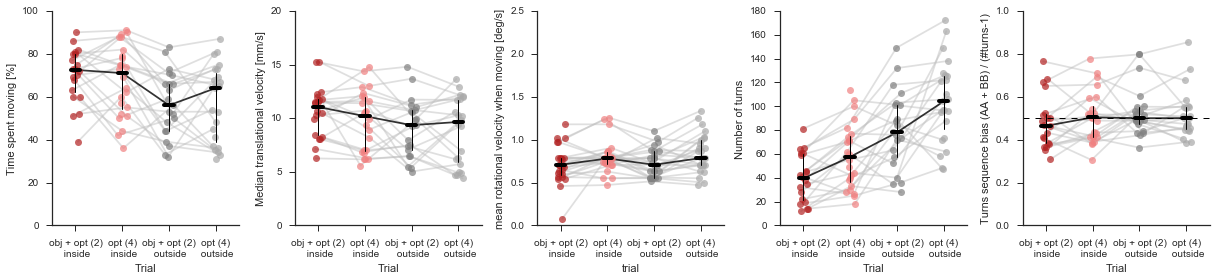

In [57]:
# make fly summary plot of residency:
arenaRad = 60
minDist = 10 #rZone_rOuter
maxDist = rZone_rOuter#arenaRad

trialIDs = [2,3,2,3]
colmap = ['firebrick','lightcoral','grey','darkgrey']
xticklabels = [trialName[2]+'\n inside',trialName[3]+'\n inside',trialName[2]+'\n outside',trialName[3]+'\n outside']
numtrials = len(trialIDs)
numVItrials = sum(['visible' in visibilityState[trial] for trial in range(len(visibilityState))])
numIVtrials = len(visibilityState)-numVItrials

minTurnDist = 5

minDists = [10,10,rZone_rOuter,rZone_rOuter]
maxDists = [rZone_rOuter,rZone_rOuter, arenaRad,arenaRad]

trialComparisonFig = plt.figure(figsize=(17,4))
trialComparisonFig = compareInsideOutsidePlot(trialComparisonFig)

try:
    mkdir(analysisDir + sep + 'compareAllTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir+'compareAllTrials/'+genotype+'_'+flyIDs[0][0]
                   +'_reinforcementTrials_'+str(minDist)+'-'+str(maxDist)+'_n'+str(len(flyIDs))+'.pdf', format='pdf')

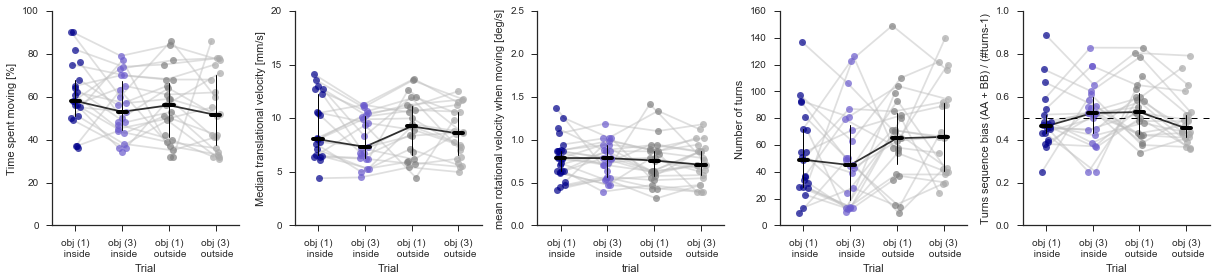

In [58]:
# make fly summary plot of residency:
trialIDs = [0,1,0,1]
colmap = ['darkblue','slateblue','grey','darkgrey']
xticklabels = [trialName[0]+'\n inside',trialName[1]+'\n inside',trialName[0]+'\n outside',trialName[1]+'\n outside']
numtrials = len(trialIDs)
numVItrials = sum(['visible' in visibilityState[trial] for trial in range(len(visibilityState))])
numIVtrials = len(visibilityState)-numVItrials

minTurnDist = 5

minDists = [10,10,rZone_rOuter,rZone_rOuter]
maxDists = [rZone_rOuter,rZone_rOuter, arenaRad,arenaRad]

trialComparisonFig = plt.figure(figsize=(17,4))
trialComparisonFig = compareInsideOutsidePlot(trialComparisonFig)

trialComparisonFig.savefig(analysisDir+'compareAllTrials/'+genotype+'_'+flyIDs[0][0]
                   +'_landmarkTrials_'+str(minDist)+'-'+str(maxDist)+'_n'+str(len(flyIDs))+'.pdf', format='pdf')